In [ ]:
"""
This is the data analysis file for somatic inhibition. It will take the data from the 
dendritic inhibition simulations. The analysis visualizes the changes in activity of the
PC based on the synaptic conductance and delays of the inhibitory synapses.
"""

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal as signal
from brian2 import *

total_time = 180*second
dt = 0.05*ms

# List to store the data
control_files = []
delay_files = []

# Load all the output files from the data_files folder
control = ['gsyn=2;delay=0.mat', 'gsyn=4;delay=0.mat', 'gsyn=8;delay=0.mat']

delay = ['gsyn=2;delay=0.5.mat', 'gsyn=4;delay=0.5.mat', 'gsyn=8;delay=0.5.mat',
    'gsyn=2;delay=1.0.mat', 'gsyn=4;delay=1.0.mat', 'gsyn=8;delay=1.0.mat',
    'gsyn=2;delay=1.5.mat', 'gsyn=4;delay=1.5.mat', 'gsyn=8;delay=1.5.mat',
    'gsyn=2;delay=2.0.mat', 'gsyn=4;delay=2.0.mat', 'gsyn=8;delay=2.0.mat',
    'gsyn=2;delay=2.5.mat', 'gsyn=4;delay=2.5.mat', 'gsyn=8;delay=2.5.mat',
    'gsyn=2;delay=3.0.mat', 'gsyn=4;delay=3.0.mat', 'gsyn=8;delay=3.0.mat',
    'gsyn=2;delay=3.5.mat', 'gsyn=4;delay=3.5.mat', 'gsyn=8;delay=3.5.mat',
    'gsyn=2;delay=4.0.mat', 'gsyn=4;delay=4.0.mat', 'gsyn=8;delay=4.0.mat',
    'gsyn=2;delay=4.5.mat', 'gsyn=4;delay=4.5.mat', 'gsyn=8;delay=4.5.mat',
    'gsyn=2;delay=5.0.mat', 'gsyn=4;delay=5.0.mat', 'gsyn=8;delay=5.0.mat']

for file_name in control:
    control_files.append(sio.loadmat(f'D:/Internship2/feedforward_sims/dendritic_inh/{file_name}'))
for file_name in delay:
    delay_files.append(sio.loadmat(f'D:/Internship2/feedforward_sims/dendritic_inh/{file_name}'))

In [3]:
def isi_threshold(isi_list):
        """
    Calculate the threshold value for inter-spike interval (ISI) list.

    Parameters:
    - isi_list (list): A list of inter-spike interval values.
    """
    #take hist val, try to find where the value is lowest on x axis
    #take the value at that point as the threshold
    hist, bins = np.histogram(isi_list, bins=int(np.sqrt(len(isi_list))), density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    min = np.min(hist)
    min_index = np.where(hist == min)
    threshold = bin_centers[min_index]
    return threshold

#count how many spikes are there in bursts and how many are isolated spikes long isi - spike - long isi : single spike
# long isi - spike - short isi: first spike of a burst ; short isi - spike - short isi: spike in a burst ; 
# short isi - spike - long isi: last spike of a burst ; N = total number of spikes ; N_single spike ; 
# fraction of single spikes = Nss/N (edited) ; fraction of spikes in burst  = (N-Nss)/N ; 
# spike rate = Nss/total time ; burst rate = N_(first spike in burst)/total time

def analyze_spikes(isi_list, total_time, isi_threshold=0.5):
    """
    Analyzes the spikes in a given ISI (Inter-Spike Interval) list and calculates and returns various metrics.
    """
    N = len(isi_list) + 1  # Total number of spikes (ISI count + 1)
    Nss = 0  # Number of single spikes
    N_first_spike_in_burst = 0  # Number of first spikes in bursts
    
    #spikes has isi1  > 100ms  isi2 > 100ms it be would single spike  - opp would beburst 

    # Iterate through the isi_list to categorize spikes
    for i in range(1, len(isi_list)):
        prev_isi = isi_list[i - 1]
        curr_isi = isi_list[i]
        
        if prev_isi > 100 and curr_isi > 100:
            Nss += 1  # Single spike (long ISI - spike - long ISI)
        elif prev_isi > 100 and curr_isi <= 100:
            N_first_spike_in_burst += 1  # First spike in burst (long ISI - spike - short ISI)
        # elif prev_isi < 100 and curr_isi <= 100:
        #       N_first_spike_in_burst += 1  # First spike in burst (long ISI - spike - short ISI)
    
    # Last spike handling: check if the last spike is a single spike or the last spike in a burst
    if isi_list[-1] > 100:
        Nss += 1  # Last spike is a single spike (long ISI - spike - long ISI)
    else:
        # If the last ISI is short, we assume it's the last spike in a burst
        pass  # Last spike of a burst doesn't increment Nss or N_first_spike_in_burst
    
    # Calculate fractions
    fraction_single_spikes = Nss / N
    fraction_spikes_in_burst = (N - Nss) / N
    
    # Calculate rates
    spike_rate = Nss / total_time
    burst_rate = N_first_spike_in_burst / total_time

    #calculate the number of spikes in a burst
    N_spikes_in_burst = N - Nss 
    
    # Output results
    results = {
        "Total Spikes (N)": N,
        "Single Spikes (Nss)": Nss,
        "First Spikes in Burst": N_first_spike_in_burst,
        "Spikes in Burst": N_spikes_in_burst,
        "Fraction of Single Spikes": fraction_single_spikes,
        "Fraction of Spikes in Burst": fraction_spikes_in_burst,
        "Spike Rate (spikes/unit time)": spike_rate,
        "Burst Rate (bursts/unit time)": burst_rate
    }
    
    return results

def plot_correlations(sig1,sig2,tau,str1,str2,ax):
    """
    Plot the correlogram between two signals. The signals are first normalized by subtracting their means. 
    The cross-correlation is calculated with a maximum lag of 20. The correlation values are normalized by the product of the 
    square roots of the sum of squares of the signals. The correlogram is then plotted using the stem plot. 
    This function is created by @Nishant_Codex.
    """
    signal1 = sig1-np.mean(sig1)
    signal2 = sig2-np.mean(sig2)
    # Calculate cross-correlation with maximum lag of 20
    correlation = signal.correlate(signal1, signal2 , mode='full')
    correlation /= np.sqrt(np.sum(signal1**2)*np.sum(signal2**2))    
    lags = signal.correlation_lags(len(signal1), len(signal1))

    # Plot the correlogram
    # lags = np.arange(-tau,tau,1/20)
    # plt.stem(lags[::100], correlation[len(correlation)//2-tau*20:len(correlation)//2+tau*20][::100])
    ax.stem(lags[len(lags)//2-100*20:len(lags)//2+100*20:100]/20, correlation[len(lags)//2-100*20:len(lags)//2+100*20:100])

    ax.set_xlabel('Lag')
    ax.set_ylabel('Correlation Coefficient')
    ax.set_title(f'Correlogram between {str1} and {str2}')
    ax.grid(True)
    # plt.show()

def color_plot_correlations(sig1,sig2,tau,str1,str2,ax,color):
    """
    Plot the correlogram between two signals. This is a modified version of the plot_correlations function with the option to plot different colors for the stem plot.
    """
    signal1 = sig1-np.mean(sig1)
    signal2 = sig2-np.mean(sig2)
    # Calculate cross-correlation with maximum lag of 20
    correlation = signal.correlate(signal1, signal2 , mode='full')
    correlation /= np.sqrt(np.sum(signal1**2)*np.sum(signal2**2))    
    lags = signal.correlation_lags(len(signal1), len(signal1))

    # Plot the correlogram
    # lags = np.arange(-tau,tau,1/20)
    # plt.stem(lags[::100], correlation[len(correlation)//2-tau*20:len(correlation)//2+tau*20][::100])
    ax.stem(lags[len(lags)//2-100*20:len(lags)//2+100*20:100]/20, correlation[len(lags)//2-100*20:len(lags)//2+100*20:100], linefmt=color, markerfmt=color, basefmt=" ")
    ax.set_xlabel('Lag')
    ax.set_ylabel('Correlation Coefficient')
    ax.set_title(f'Correlogram between {str1} and {str2}')
    ax.grid(True)
    # plt.show()



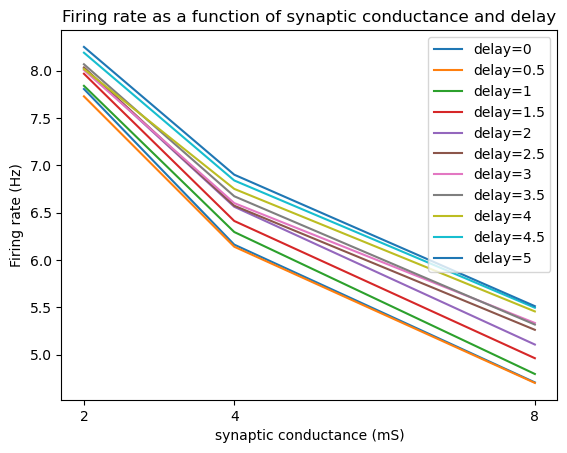

In [4]:
#calculate firing rates for control and delay conditions of pyramidal cells
control_rates = []
delay_rates = []
for i in range(len(control_files)):
    control_rates.append(control_files[i]['S_pyr_spikes'][0])
for i in range(len(delay_files)):
    delay_rates.append(delay_files[i]['S_pyr_spikes'][0])

#calculate firing rates 
firing_rates = []
for i in range(len(control_rates)):
    firing_rates.append(len(control_rates[i])/total_time)
for i in range(len(delay_rates)):
    firing_rates.append(len(delay_rates[i])/total_time)

#extract the gsyn values from the file names
gsyn_values = []
for file_name in control:
    gsyn_values.append(int(file_name.split(';')[0].split('=')[1]))

#plot the firing rates as a function of gsyn and delay on x-axis
plt.figure()
plt.plot(gsyn_values, firing_rates[0:3], label='delay=0')
plt.plot(gsyn_values, firing_rates[3:6], label='delay=0.5')
plt.plot(gsyn_values, firing_rates[6:9], label='delay=1')
plt.plot(gsyn_values, firing_rates[9:12], label='delay=1.5')
plt.plot(gsyn_values, firing_rates[12:15], label='delay=2')
plt.plot(gsyn_values, firing_rates[15:18], label='delay=2.5')
plt.plot(gsyn_values, firing_rates[18:21], label='delay=3')
plt.plot(gsyn_values, firing_rates[21:24], label='delay=3.5')
plt.plot(gsyn_values, firing_rates[24:27], label='delay=4')
plt.plot(gsyn_values, firing_rates[27:30], label='delay=4.5')
plt.plot(gsyn_values, firing_rates[30:33], label='delay=5')
plt.xlabel('synaptic conductance (mS)')
plt.ylabel('Firing rate (Hz)')
plt.xticks(gsyn_values)
plt.title('Firing rate as a function of synaptic conductance and delay')
plt.legend()
plt.show()


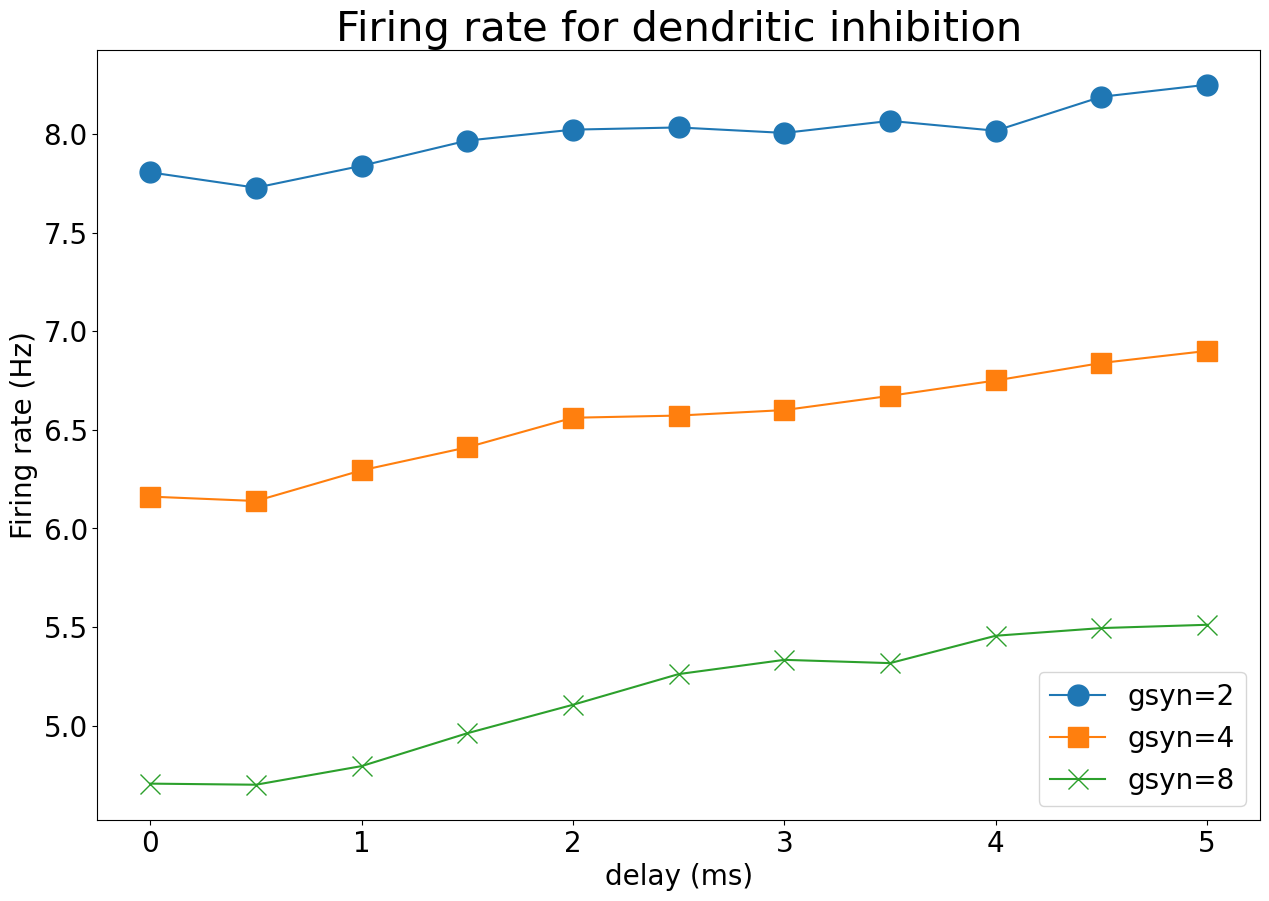

In [5]:
#line plot of firing rates as a function of delay for each gsyn value
plt.figure(figsize=(15, 10))
plt.plot(np.arange(0, 5.5, 0.5), firing_rates[0:33:3], label='gsyn=2', marker='o', markersize=15)
plt.plot(np.arange(0, 5.5, 0.5), firing_rates[1:33:3], label='gsyn=4', marker='s', markersize=15)
plt.plot(np.arange(0, 5.5, 0.5), firing_rates[2:33:3], label='gsyn=8', marker='x', markersize=15)
plt.xlabel('delay (ms)',fontsize=20)
plt.ylabel('Firing rate (Hz)',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Firing rate for dendritic inhibition',fontsize=30)
plt.legend(fontsize=20)
plt.show()

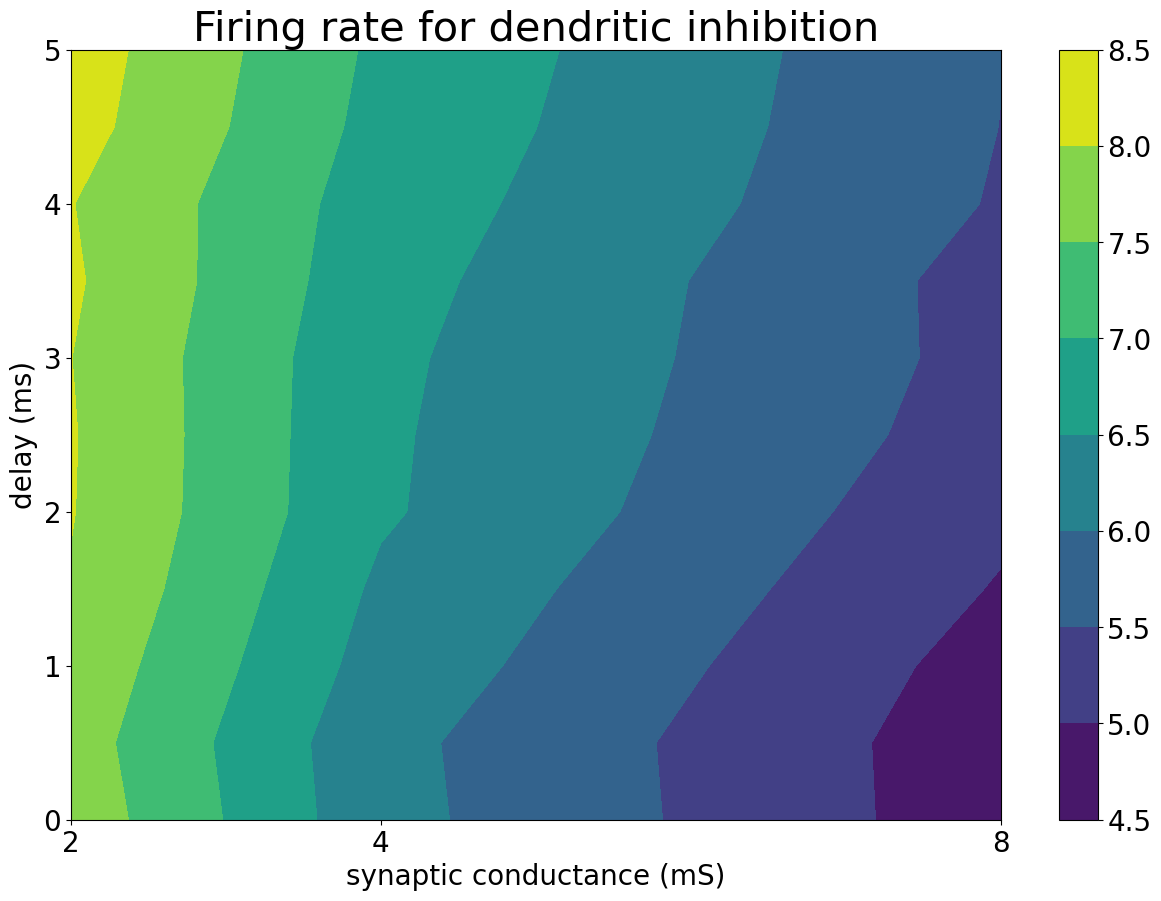

In [6]:
#color plot of firing rates as a function of gsyn and delay
delay_values = np.arange(0,5.5,0.5)
firing_rates = np.array(firing_rates).reshape((11,3))
plt.figure(figsize=(15,10))
plt.contourf(gsyn_values,delay_values,firing_rates)
plt.xlabel('synaptic conductance (mS)',fontsize=20)
plt.ylabel('delay (ms)',fontsize=20)
plt.xticks([2,4,8],fontsize=20)
plt.yticks(fontsize=20)
plt.title('Firing rate for dendritic inhibition',fontsize=30)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
plt.show()

In [7]:
#setting markers for the scatter plot
points = {
    (2, 0): 'o',
    (4, 0): 's',
    (8, 0): 'D',
    (2, 0.5): 'x',
    (4, 0.5): '^',
    (8, 0.5): 'v',
    (2, 1): '<',
    (4, 1): '>',
    (8, 1): 'p',
    (2, 1.5): 'h',
    (4, 1.5): 'H',
    (8, 1.5): '+',
    (2, 2): 'd',
    (4, 2): '|',
    (8, 2): '_',
    (2, 2.5): '1',
    (4, 2.5): '2',
    (8, 2.5): '3',
    (2, 3): '4',
    (4, 3): '8',
    (8, 3): 's',
    (2, 3.5): 'p',
    (4, 3.5): '*',
    (8, 3.5): 'h',
    (2, 4): 'H',
    (4, 4): 'X',
    (8, 4): 'D',
    (2, 4.5): 'd',
    (4, 4.5): 'P',
    (8, 4.5): 'X',
    (2, 5): 'o',
    (4, 5): 's',
    (8, 5): 'D'
}

colors = {
    (2, 0): 'red',
    (4, 0): 'blue',
    (8, 0): 'green',
    (2, 0.5): 'purple',
    (4, 0.5): 'orange',
    (8, 0.5): 'brown',
    (2, 1): 'pink',
    (4, 1): 'gray',
    (8, 1): 'olive',
    (2, 1.5): 'cyan',
    (4, 1.5): 'magenta',
    (8, 1.5): 'yellow',
    (2, 2): 'black',
    (4, 2): 'lime',
    (8, 2): 'teal',
    (2, 2.5): 'navy',
    (4, 2.5): 'maroon',
    (8, 2.5): 'aqua',
    (2, 3): 'gold',
    (4, 3): 'silver',
    (8, 3): 'coral',
    (2, 3.5): 'orchid',
    (4, 3.5): 'plum',
    (8, 3.5): 'salmon',
    (2, 4): 'khaki',
    (4, 4): 'lavender',
    (8, 4): 'turquoise',
    (2, 4.5): 'peachpuff',
    (4, 4.5): 'peru',
    (8, 4.5): 'slateblue',
    (2, 5): 'tomato',
    (4, 5): 'wheat',
    (8, 5): 'seagreen'
}


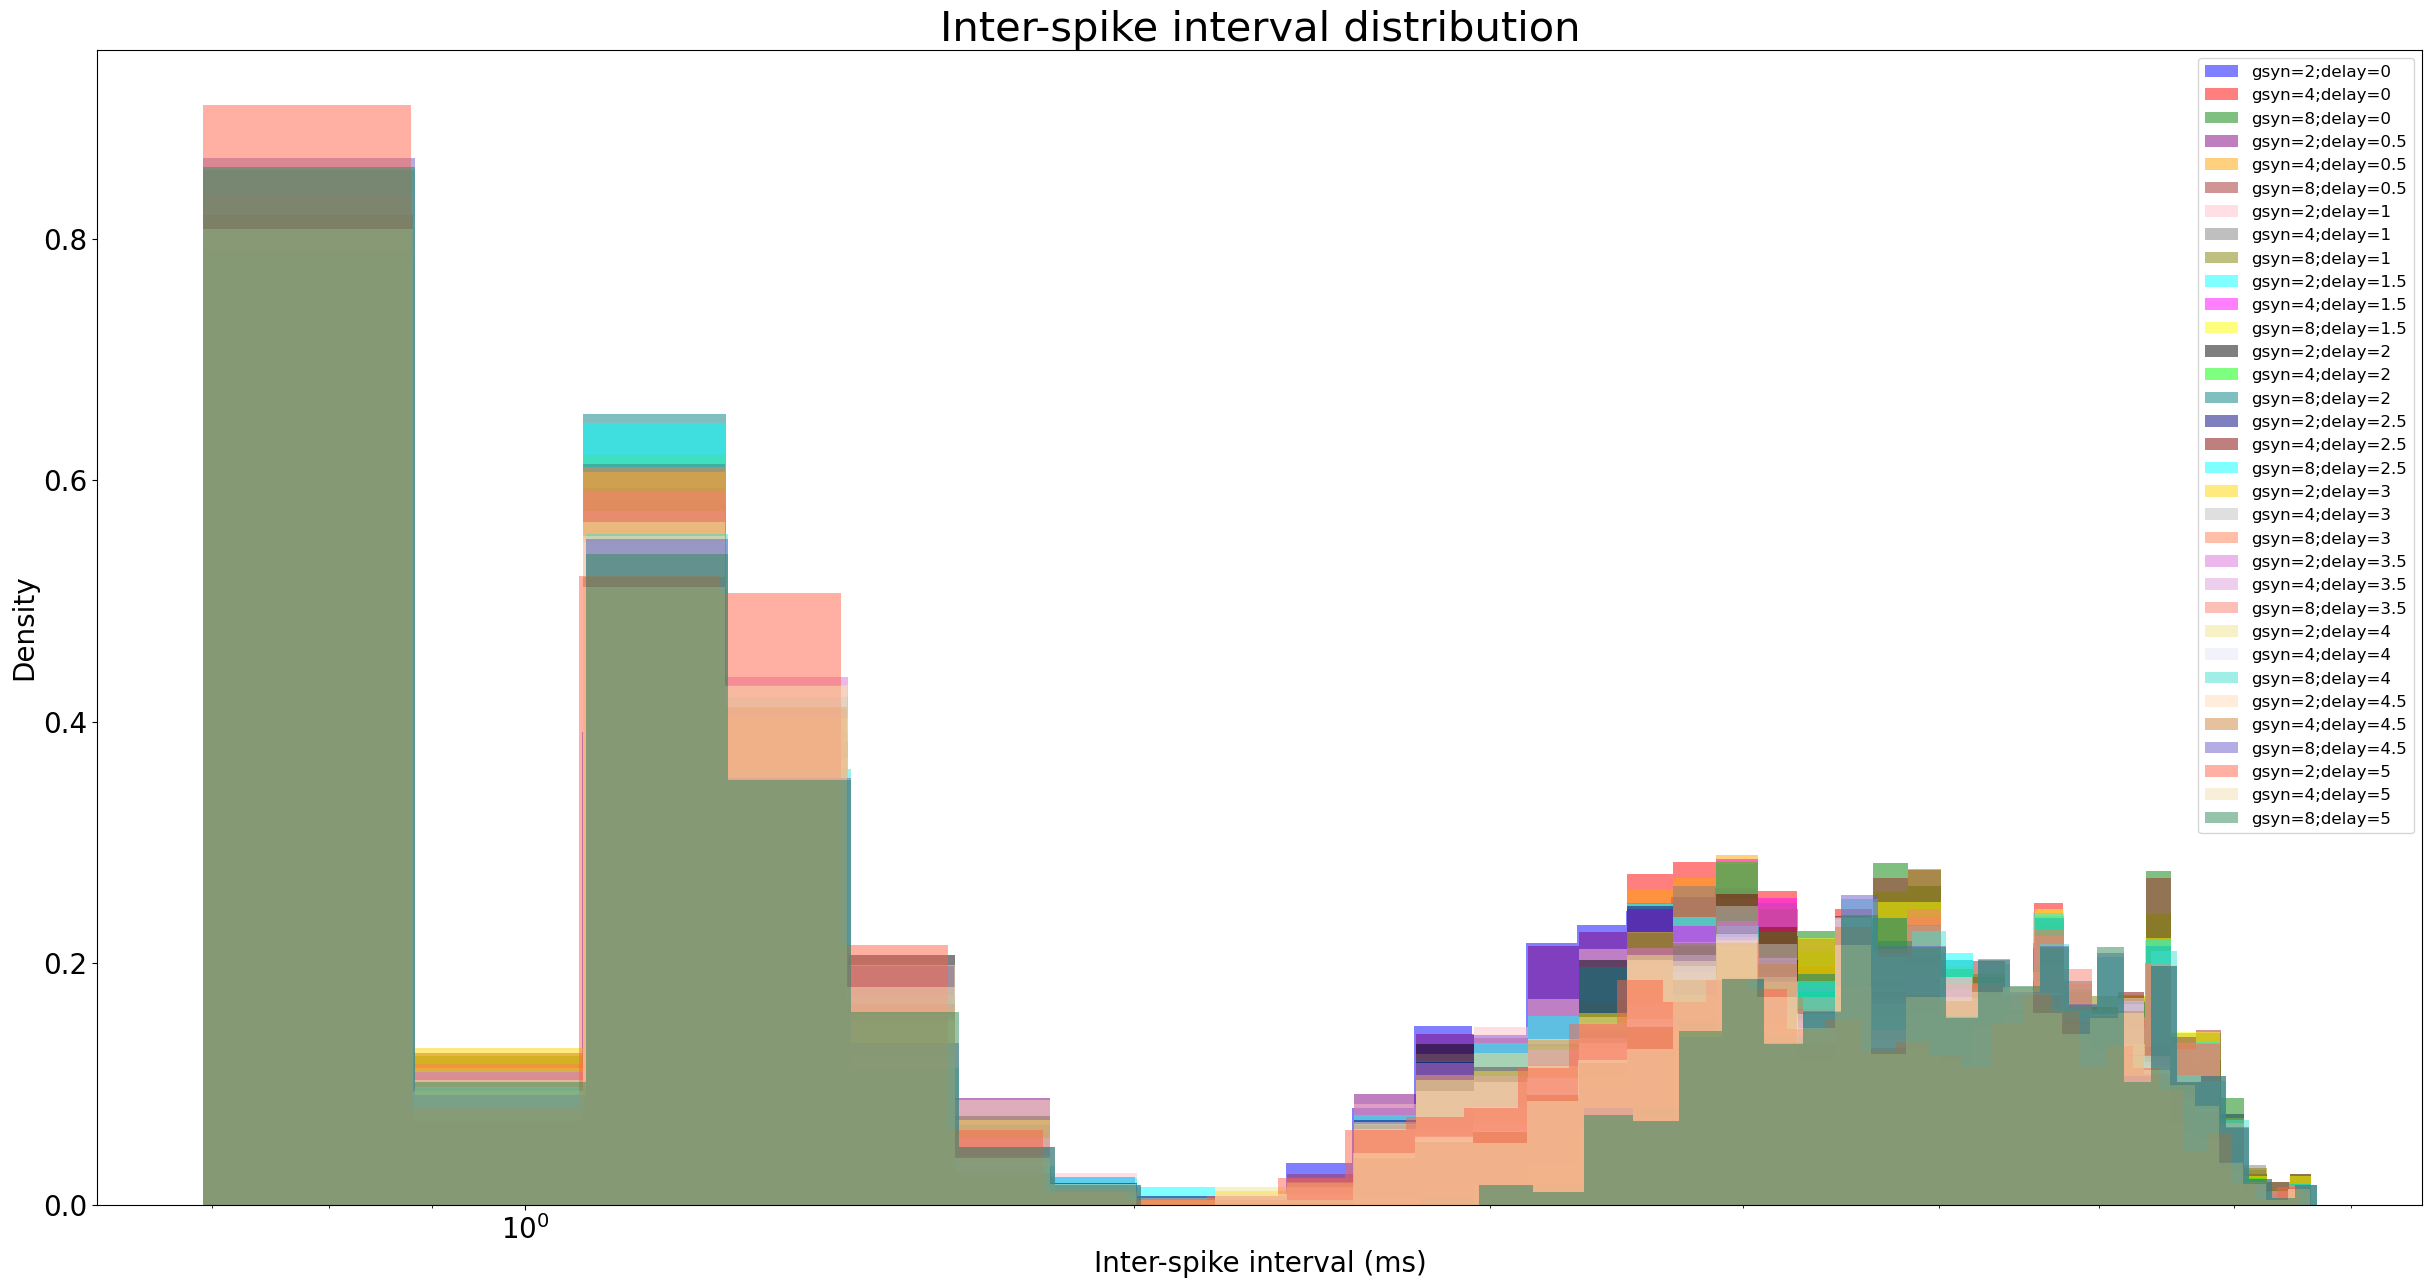

In [50]:
#calculate inter-spike intervals
isi = []
for i in range(len(control_files)):
    isi.append(np.diff(control_files[i]['S_pyr_spikes'][0])*1000) #convert to ms
for i in range(len(delay_files)):
    isi.append(np.diff(delay_files[i]['S_pyr_spikes'][0])*1000) #convert to ms

num_bins = int(np.sqrt(len(isi[0])))

#plot the inter-spike intervals
plt.figure(figsize=(30,15))
plt.hist(np.log(isi[0]), bins=num_bins, density=True, alpha=0.5, label='gsyn=2;delay=0', color='blue')
plt.hist(np.log(isi[1]), bins=num_bins, density=True, alpha=0.5, label='gsyn=4;delay=0', color='red')
plt.hist(np.log(isi[2]), bins=num_bins, density=True, alpha=0.5, label='gsyn=8;delay=0', color='green')
plt.hist(np.log(isi[3]), bins=num_bins, density=True, alpha=0.5, label='gsyn=2;delay=0.5', color='purple')
plt.hist(np.log(isi[4]), bins=num_bins, density=True, alpha=0.5, label='gsyn=4;delay=0.5', color='orange')
plt.hist(np.log(isi[5]), bins=num_bins, density=True, alpha=0.5, label='gsyn=8;delay=0.5', color='brown')
plt.hist(np.log(isi[6]), bins=num_bins, density=True, alpha=0.5, label='gsyn=2;delay=1', color='pink')
plt.hist(np.log(isi[7]), bins=num_bins, density=True, alpha=0.5, label='gsyn=4;delay=1', color='gray')
plt.hist(np.log(isi[8]), bins=num_bins, density=True, alpha=0.5, label='gsyn=8;delay=1', color='olive')
plt.hist(np.log(isi[9]), bins=num_bins, density=True, alpha=0.5, label='gsyn=2;delay=1.5', color='cyan')
plt.hist(np.log(isi[10]), bins=num_bins, density=True, alpha=0.5, label='gsyn=4;delay=1.5', color='magenta')
plt.hist(np.log(isi[11]), bins=num_bins, density=True, alpha=0.5, label='gsyn=8;delay=1.5', color='yellow')
plt.hist(np.log(isi[12]), bins=num_bins, density=True, alpha=0.5, label='gsyn=2;delay=2', color='black')
plt.hist(np.log(isi[13]), bins=num_bins, density=True, alpha=0.5, label='gsyn=4;delay=2', color='lime')
plt.hist(np.log(isi[14]), bins=num_bins, density=True, alpha=0.5, label='gsyn=8;delay=2', color='teal')
plt.hist(np.log(isi[15]), bins=num_bins, density=True, alpha=0.5, label='gsyn=2;delay=2.5', color='navy')
plt.hist(np.log(isi[16]), bins=num_bins, density=True, alpha=0.5, label='gsyn=4;delay=2.5', color='maroon')
plt.hist(np.log(isi[17]), bins=num_bins, density=True, alpha=0.5, label='gsyn=8;delay=2.5', color='aqua')
plt.hist(np.log(isi[18]), bins=num_bins, density=True, alpha=0.5, label='gsyn=2;delay=3', color='gold')
plt.hist(np.log(isi[19]), bins=num_bins, density=True, alpha=0.5, label='gsyn=4;delay=3', color='silver')
plt.hist(np.log(isi[20]), bins=num_bins, density=True, alpha=0.5, label='gsyn=8;delay=3', color='coral')
plt.hist(np.log(isi[21]), bins=num_bins, density=True, alpha=0.5, label='gsyn=2;delay=3.5', color='orchid')
plt.hist(np.log(isi[22]), bins=num_bins, density=True, alpha=0.5, label='gsyn=4;delay=3.5', color='plum')
plt.hist(np.log(isi[23]), bins=num_bins, density=True, alpha=0.5, label='gsyn=8;delay=3.5', color='salmon')
plt.hist(np.log(isi[24]), bins=num_bins, density=True, alpha=0.5, label='gsyn=2;delay=4', color='khaki')
plt.hist(np.log(isi[25]), bins=num_bins, density=True, alpha=0.5, label='gsyn=4;delay=4', color='lavender')
plt.hist(np.log(isi[26]), bins=num_bins, density=True, alpha=0.5, label='gsyn=8;delay=4', color='turquoise')
plt.hist(np.log(isi[27]), bins=num_bins, density=True, alpha=0.5, label='gsyn=2;delay=4.5', color='peachpuff')
plt.hist(np.log(isi[28]), bins=num_bins, density=True, alpha=0.5, label='gsyn=4;delay=4.5', color='peru')
plt.hist(np.log(isi[29]), bins=num_bins, density=True, alpha=0.5, label='gsyn=8;delay=4.5', color='slateblue')
plt.hist(np.log(isi[30]), bins=num_bins, density=True, alpha=0.5, label='gsyn=2;delay=5', color='tomato')
plt.hist(np.log(isi[31]), bins=num_bins, density=True, alpha=0.5, label='gsyn=4;delay=5', color='wheat')
plt.hist(np.log(isi[32]), bins=num_bins, density=True, alpha=0.5, label='gsyn=8;delay=5', color='seagreen')
plt.xlabel('Inter-spike interval (ms)', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.xscale('log')
plt.title('Inter-spike interval distribution', fontsize=30)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

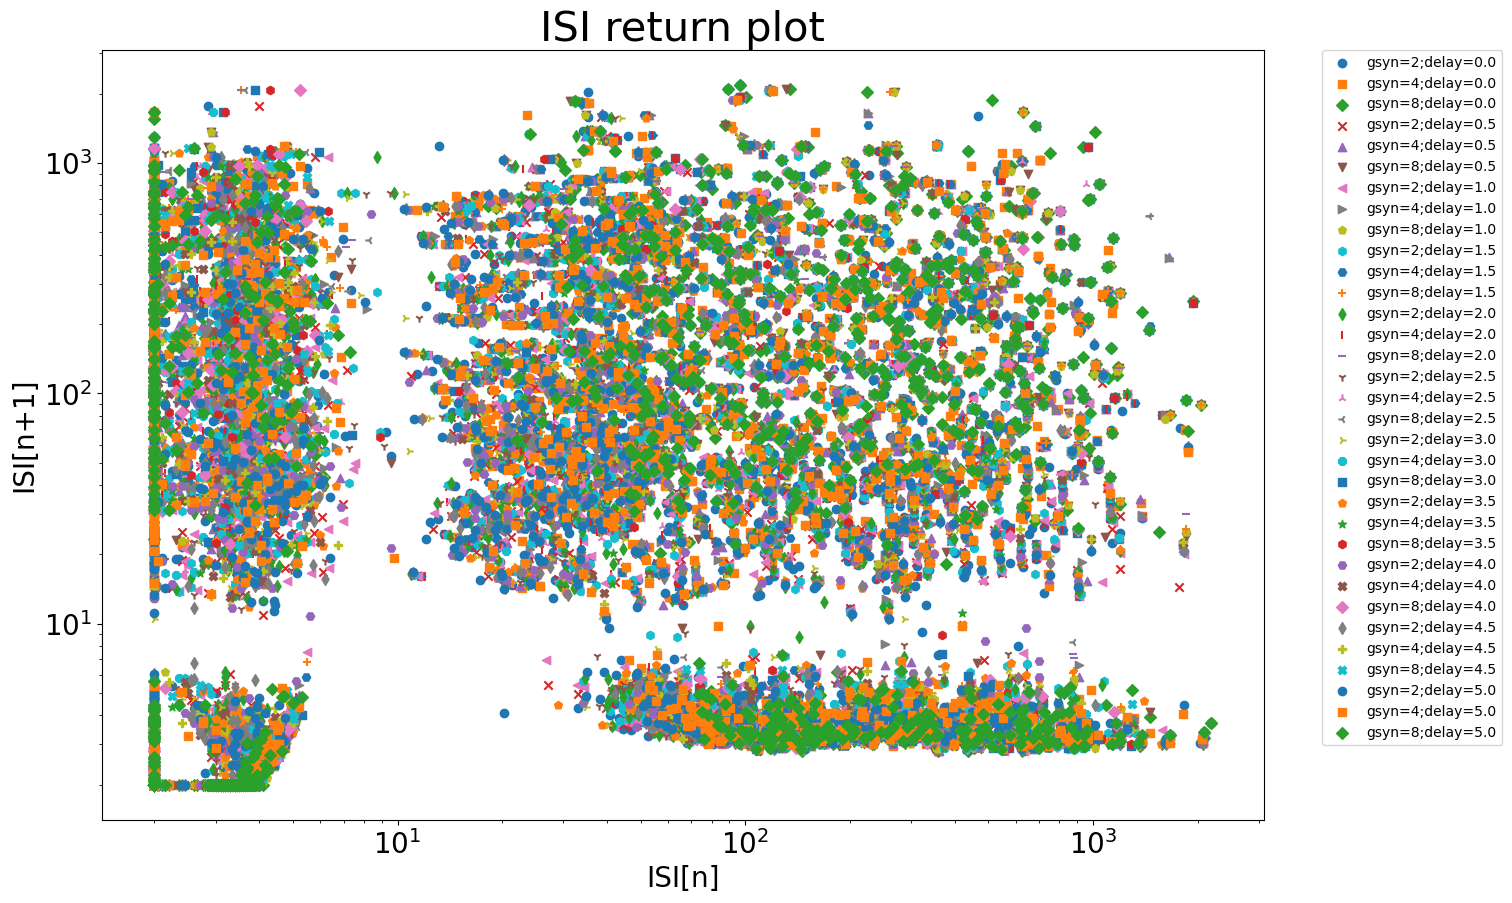

In [10]:
# return plot of inter-spike intervals
plt.figure(figsize=(15,10))
for i in range(33):
    gsyn = gsyn_values[i % 3]
    delay = delay_values[i // 3]
    plt.scatter(isi[i][:-1], isi[i][1:], label=f'gsyn={gsyn};delay={delay}', marker=points[(gsyn, delay)])

plt.xlabel('ISI[n]', fontsize=20)
plt.ylabel('ISI[n+1]', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.title('ISI return plot', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.show()

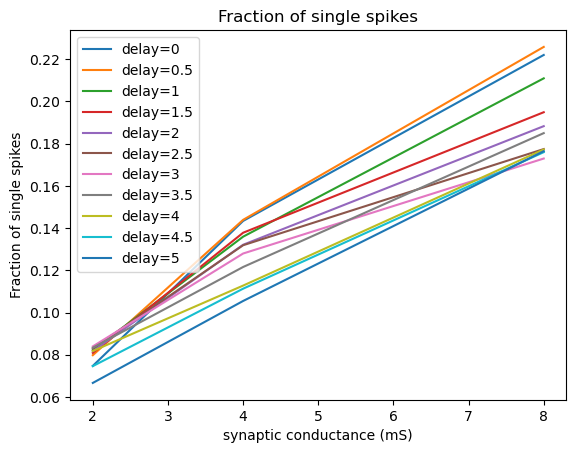

In [11]:
isi_thresholds = []
for i in range(len(isi)):
    isi_thresholds.append((isi_threshold(isi[i])))

#analyze the spikes to determine the number of single spikes and spikes in bursts
results = []
for i in range(len(isi)):
    results.append(analyze_spikes(isi[i], total_time, isi_thresholds[i]))

#plot the fraction of single spikes and spikes in bursts as a function of gsyn and delay
fraction_single_spikes = []
fraction_spikes_in_burst = []
for i in range(len(results)):
    fraction_single_spikes.append(results[i]['Fraction of Single Spikes'])
    fraction_spikes_in_burst.append(results[i]['Fraction of Spikes in Burst'])

plt.figure()
plt.plot(gsyn_values, fraction_single_spikes[0:3], label='delay=0')
plt.plot(gsyn_values, fraction_single_spikes[3:6], label='delay=0.5')
plt.plot(gsyn_values, fraction_single_spikes[6:9], label='delay=1')
plt.plot(gsyn_values, fraction_single_spikes[9:12], label='delay=1.5')
plt.plot(gsyn_values, fraction_single_spikes[12:15], label='delay=2')
plt.plot(gsyn_values, fraction_single_spikes[15:18], label='delay=2.5')
plt.plot(gsyn_values, fraction_single_spikes[18:21], label='delay=3')
plt.plot(gsyn_values, fraction_single_spikes[21:24], label='delay=3.5')
plt.plot(gsyn_values, fraction_single_spikes[24:27], label='delay=4')
plt.plot(gsyn_values, fraction_single_spikes[27:30], label='delay=4.5')
plt.plot(gsyn_values, fraction_single_spikes[30:33], label='delay=5')
plt.xlabel('synaptic conductance (mS)')
plt.ylabel('Fraction of single spikes')
plt.title('Fraction of single spikes')
plt.xticks
plt.legend()
plt.show()

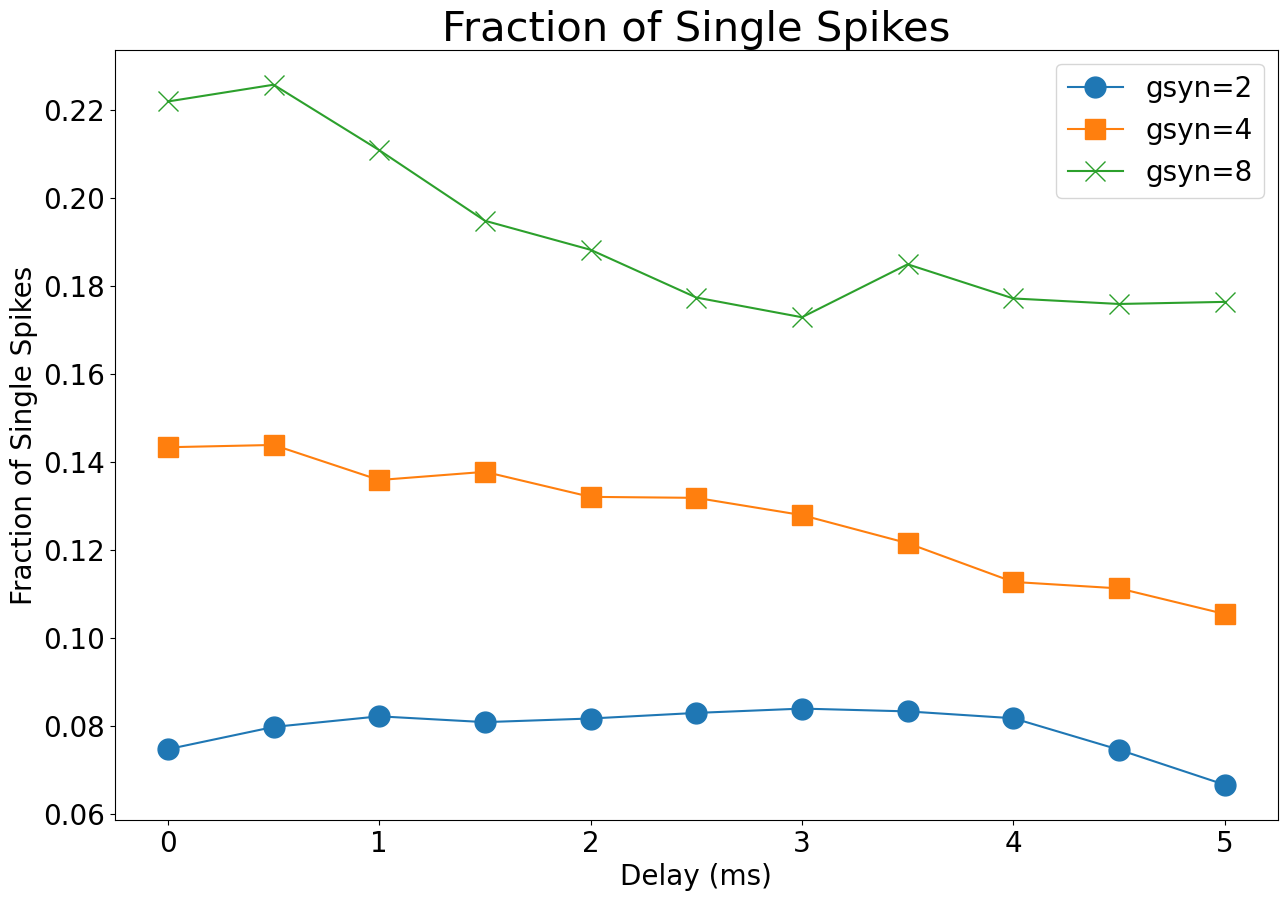

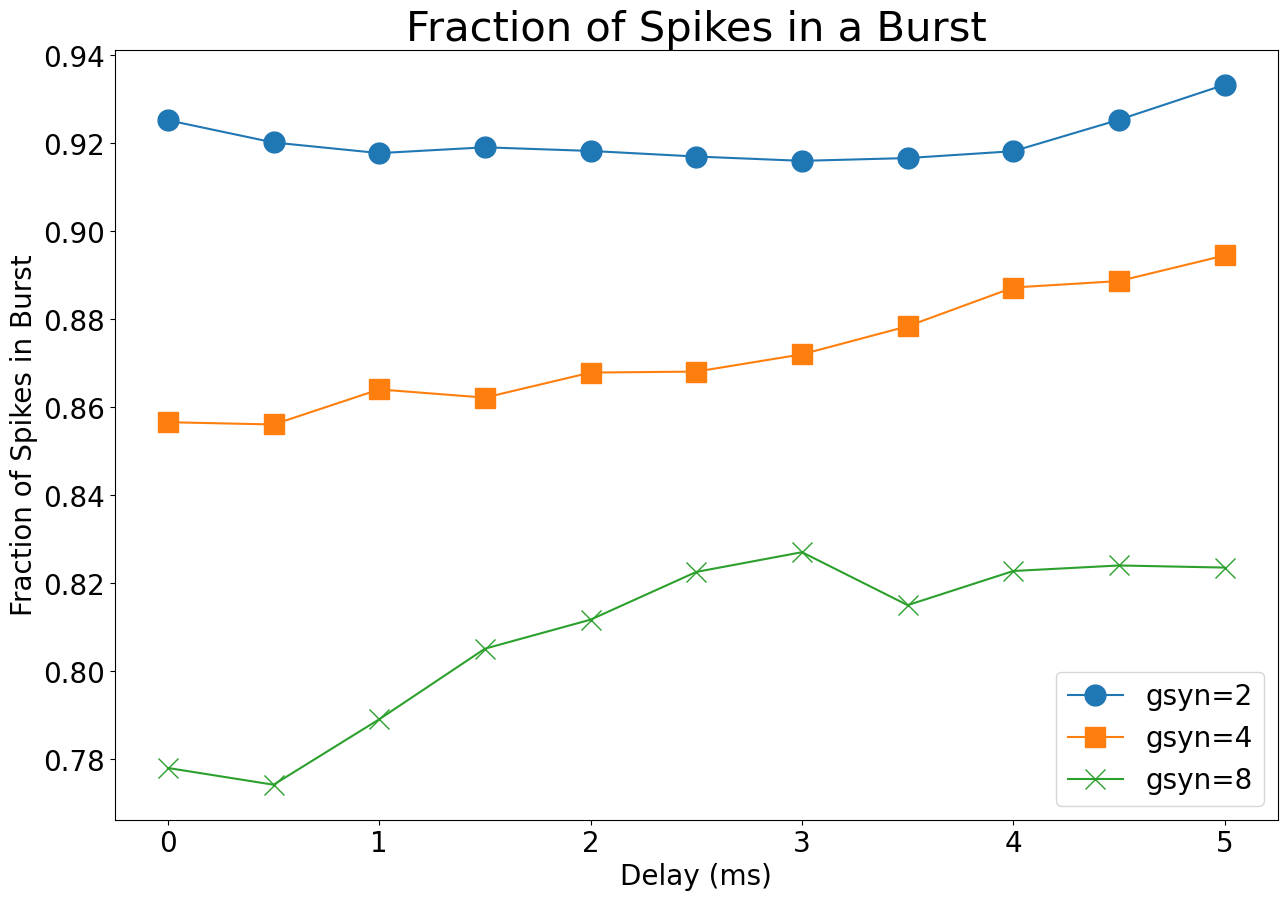

In [14]:
# Analyze the spikes for each condition
spike_results = []
for i in range(len(isi)):
    spike_results.append(analyze_spikes(isi[i], total_time, isi_threshold=isi_thresholds[i]))

# Extract the fraction of single spikes and spikes in burst for each condition
fraction_single_spikes = []
fraction_spikes_in_burst = []
for i in range(len(spike_results)):
    fraction_single_spikes.append(spike_results[i]["Fraction of Single Spikes"])
    fraction_spikes_in_burst.append(spike_results[i]["Fraction of Spikes in Burst"])

# Plot the fraction of single spikes and spikes in burst as a function of gsyn and delay
plt.figure(figsize=(15, 10))
plt.plot(np.arange(0, 5.5, 0.5), fraction_single_spikes[0:33:3], label='gsyn=2', marker='o', markersize=15)
plt.plot(np.arange(0, 5.5, 0.5), fraction_single_spikes[1:33:3], label='gsyn=4', marker='s', markersize=15)
plt.plot(np.arange(0, 5.5, 0.5), fraction_single_spikes[2:33:3], label='gsyn=8', marker='x', markersize=15)
plt.xlabel('Delay (ms)',fontsize=20)
plt.ylabel('Fraction of Single Spikes',fontsize=20)
plt.title('Fraction of Single Spikes',fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.show()

plt.figure(figsize=(15, 10))
plt.plot(np.arange(0, 5.5, 0.5), fraction_spikes_in_burst[0:33:3], label='gsyn=2', marker='o', markersize=15)
plt.plot(np.arange(0, 5.5, 0.5), fraction_spikes_in_burst[1:33:3], label='gsyn=4', marker='s', markersize=15)
plt.plot(np.arange(0, 5.5, 0.5), fraction_spikes_in_burst[2:33:3], label='gsyn=8', marker='x', markersize=15)
plt.xlabel('Delay (ms)',fontsize=20)
plt.ylabel('Fraction of Spikes in Burst',fontsize=20)
plt.title('Fraction of Spikes in a Burst',fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.show()

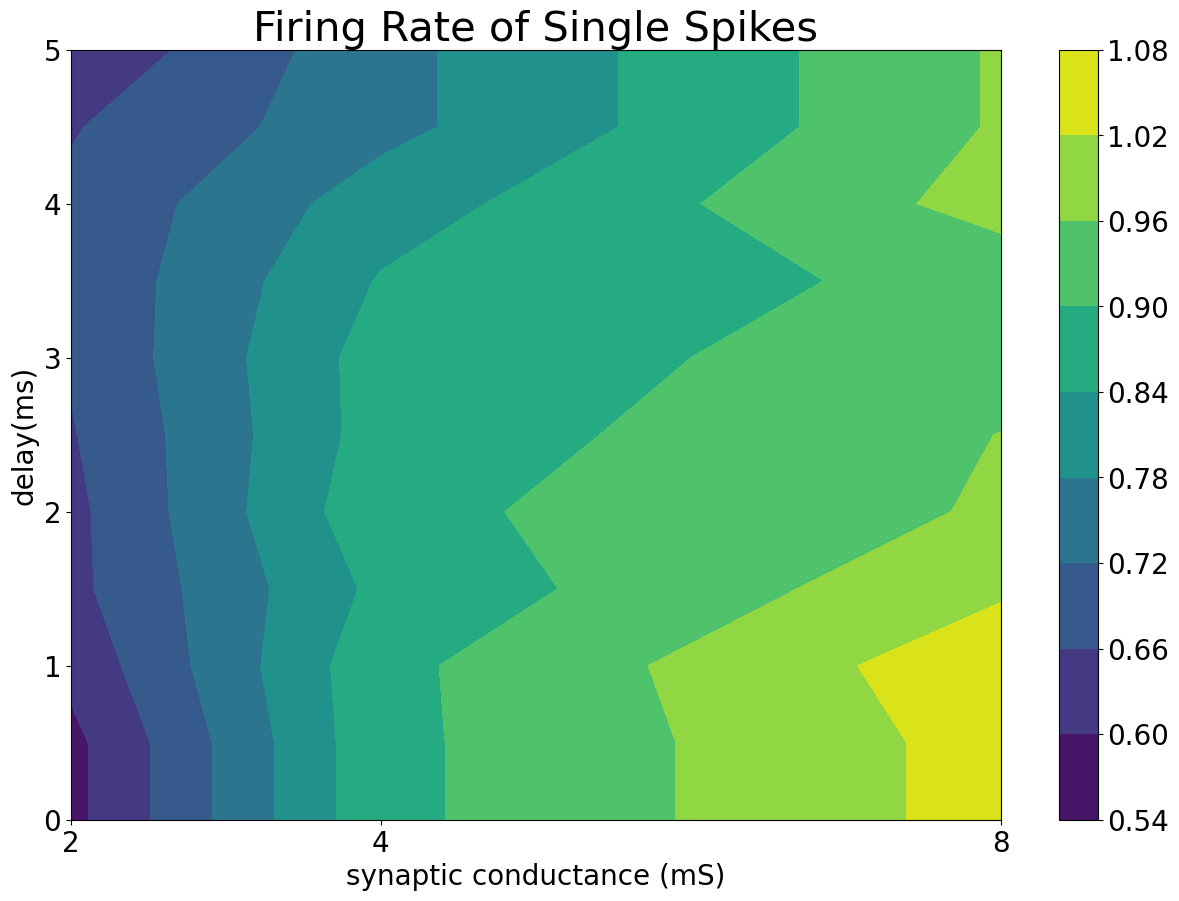

In [17]:
single_spike_counts = []
for i in range(len(control_files)):
    single_spike_counts.append(results[i]['Single Spikes (Nss)'])
for i in range(len(delay_files)):
    single_spike_counts.append(results[i]['Single Spikes (Nss)'])

#calculate firing rate of single spikes for each condition
single_spike_firing_rates = []
for i in range(len(control_files)):
    single_spike_firing_rates.append(results[i]['Spike Rate (spikes/unit time)'])
for i in range(len(delay_files)):
    single_spike_firing_rates.append(results[i]['Spike Rate (spikes/unit time)'])

gsyn_values = [2,4,8]
single_spike_firing_rates = np.array(single_spike_firing_rates).reshape((11,3))
plt.figure(figsize=(15,10))
plt.contourf(gsyn_values,delay_values,single_spike_firing_rates)
plt.xticks([2,4,8],fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('synaptic conductance (mS)',fontsize=20)
plt.ylabel('delay(ms)',fontsize=20)
plt.title('Firing Rate of Single Spikes',fontsize=30)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
plt.show()


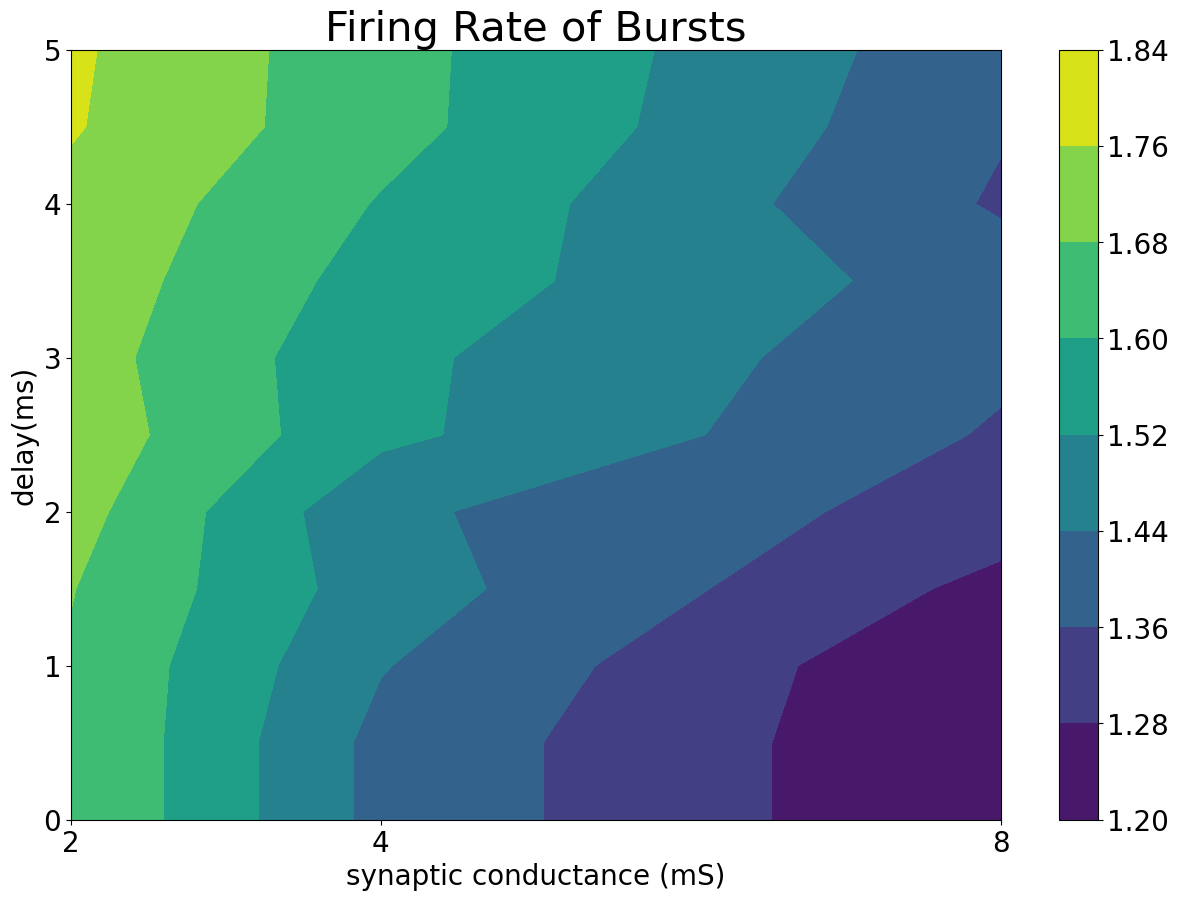

In [18]:
spikes_in_burst = []
for i in range(len(control_files)):
    spikes_in_burst.append(results[i]['Spikes in Burst'])
for i in range(len(delay_files)):
    spikes_in_burst.append(results[i]['Spikes in Burst'])

#calculate firing rate of spikes in a burst for each condition
burst_firing_rates = []
for i in range(len(control_files)):
    burst_firing_rates.append(results[i]['Burst Rate (bursts/unit time)'])
for i in range(len(delay_files)):
    burst_firing_rates.append(results[i]['Burst Rate (bursts/unit time)'])

burst_firing_rates = np.array(burst_firing_rates).reshape((11,3))
plt.figure(figsize=(15,10))
plt.contourf(gsyn_values,delay_values,burst_firing_rates)
plt.xlabel('synaptic conductance (mS)',fontsize=20)
plt.ylabel('delay(ms)',fontsize=20)
plt.title('Firing Rate of Bursts',fontsize=30)
plt.xticks(gsyn_values,fontsize=20)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
plt.show()


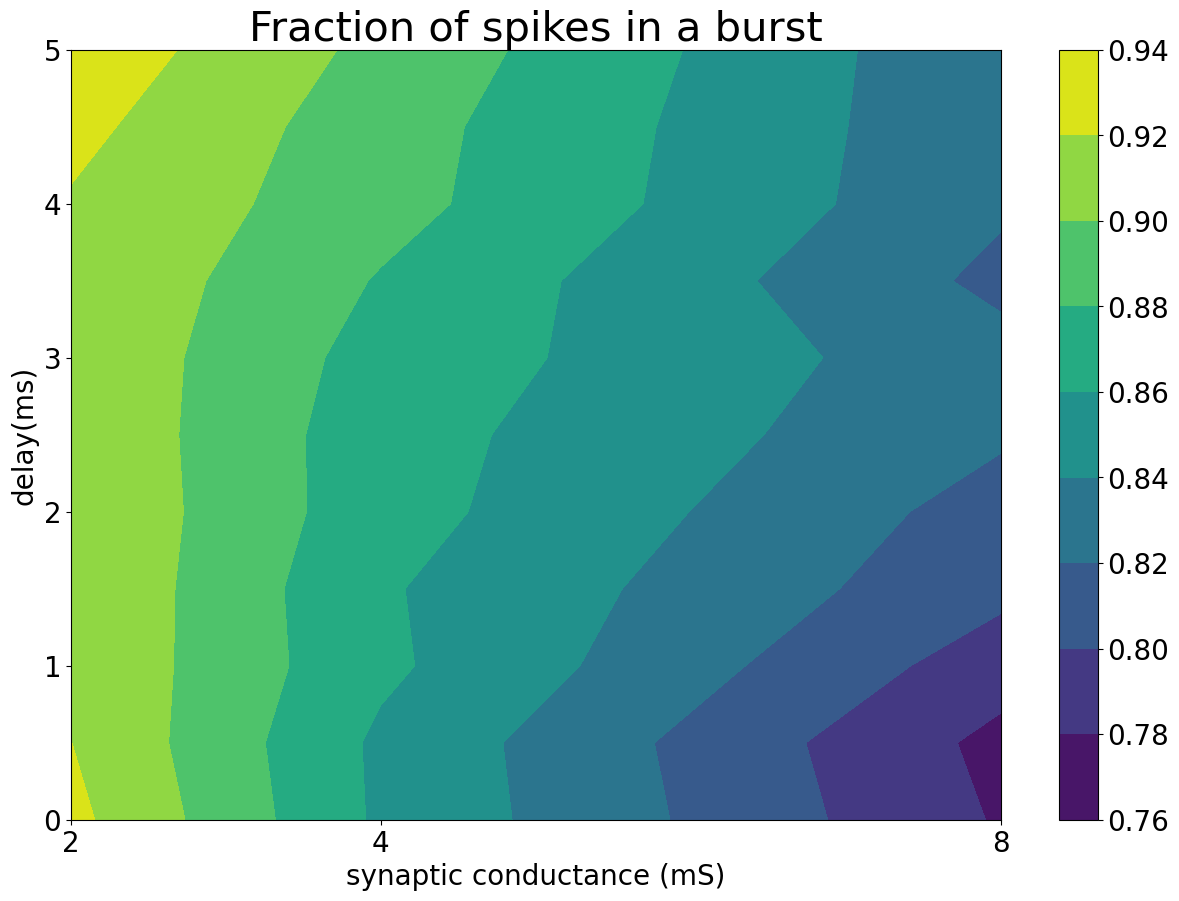

In [19]:
#plot burst percentage as a function of gsyn and delay
burst_percentage = []
for i in range(len(results)):
    burst_percentage.append(results[i]['Fraction of Spikes in Burst'])
    
burst_percentage = np.array(burst_percentage).reshape((11,3))
plt.figure(figsize=(15,10))
plt.contourf(gsyn_values,delay_values,burst_percentage)
plt.xlabel('synaptic conductance (mS)',fontsize=20)
plt.ylabel('delay(ms)',fontsize=20)
plt.title('Fraction of spikes in a burst',fontsize=30)
plt.xticks(gsyn_values,fontsize=20)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
plt.show()

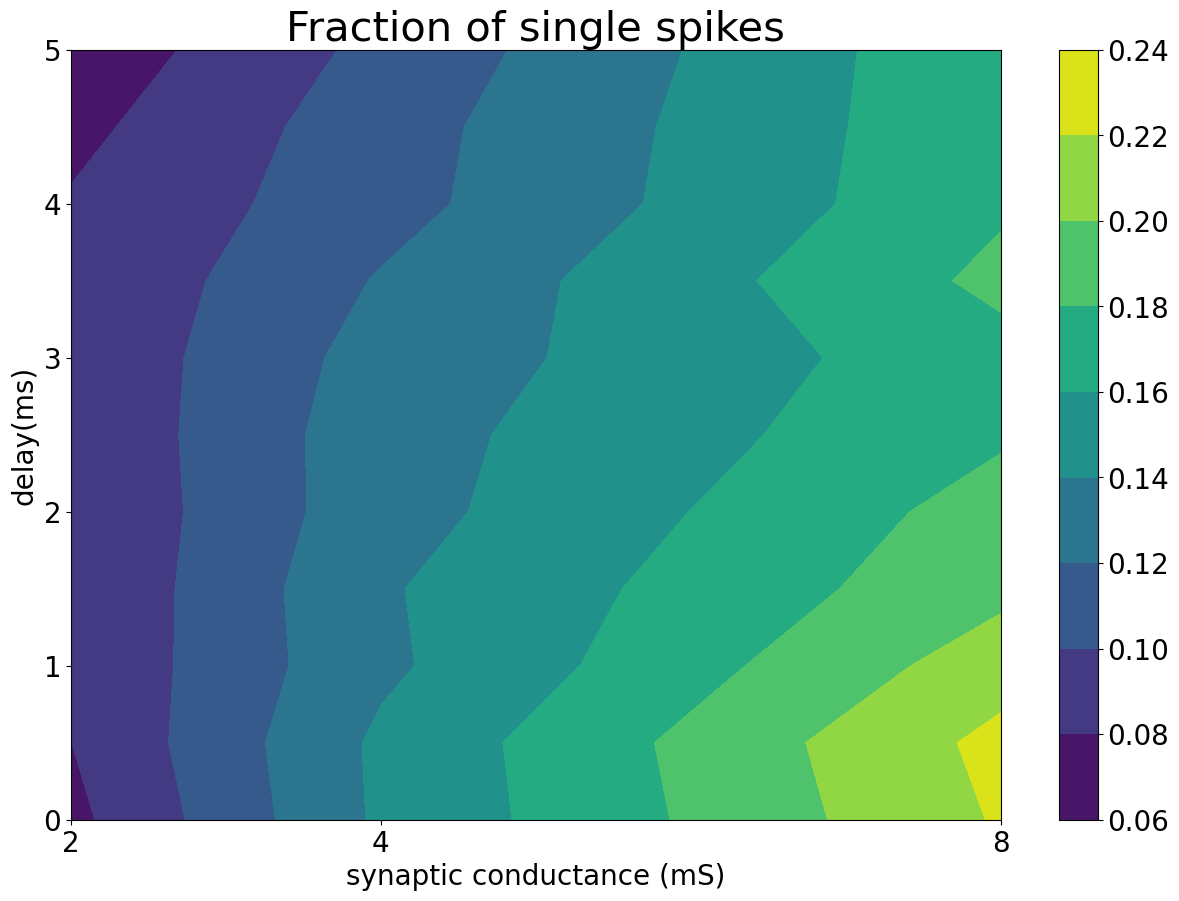

In [20]:
#plot fraction of single spikes as a function of gsyn and delay
fraction_single_spikes = []
for result in results:
    fraction_single_spikes.append(result["Fraction of Single Spikes"])
fraction_single_spikes = np.array(fraction_single_spikes).reshape((11,3))

plt.figure(figsize=(15,10))
plt.contourf(gsyn_values,delay_values,fraction_single_spikes)
plt.xlabel('synaptic conductance (mS)',fontsize=20)
plt.ylabel('delay(ms)',fontsize=20)
plt.title('Fraction of single spikes',fontsize=30)
plt.xticks(gsyn_values,fontsize=20)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
plt.show()

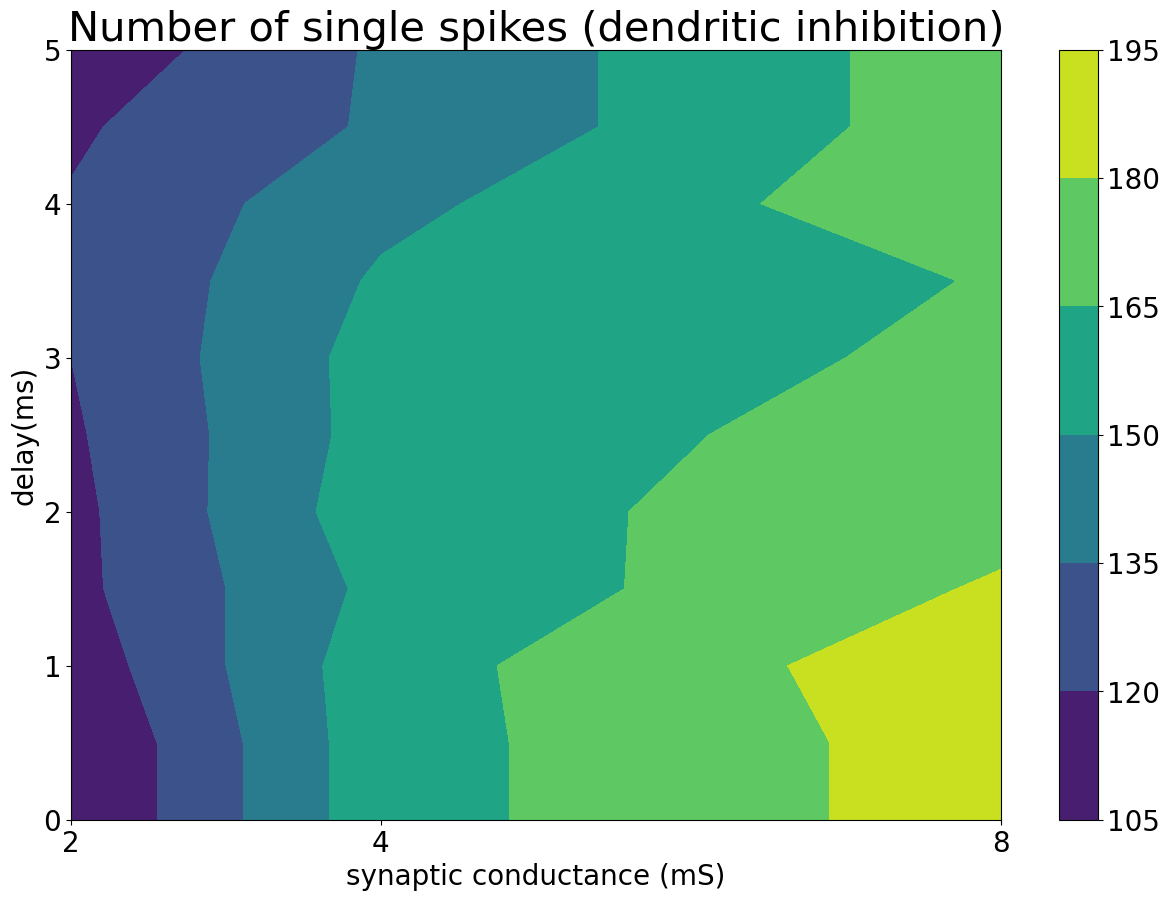

In [21]:
#plot number of single spikes as a function of gsyn and delay
single_spike_counts = np.array(single_spike_counts).reshape((11,3))
plt.figure(figsize=(15,10))
plt.contourf(gsyn_values,delay_values,single_spike_counts)
plt.xlabel('synaptic conductance (mS)',fontsize=20)
plt.ylabel('delay(ms)',fontsize=20)
plt.title('Number of single spikes (dendritic inhibition)',fontsize=30)
plt.xticks(gsyn_values,fontsize=20)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
plt.show()

In [23]:
#calculate PSDs for subthreshold membrane potential and plot impedence for all gsyn and delay conditions in one plot
# Parameters
fs = 1 / dt  # Sampling frequency
window_length = 3*second  # Length of each window in seconds
nperseg = int(window_length * fs)  # Convert window length to number of samples

Is_FN = []
for i in range(len(control_files[0])):
    Is_FN.append(control_files[0]['Pyr_Is_FN'])

Vs = []
for i in range(len(control_files)):
    Vs.append(control_files[i]['Pyr_Vs'])
for i in range(len(delay_files)):
    Vs.append(delay_files[i]['Pyr_Vs'])

#get subthreshold membrane potentials for membrane potentials in all the files
Vs_sub = []
for i in range(len(Vs)):
    Vs_sub.append(Vs[i])
    Vs_sub[i][Vs_sub[i] < -20] = np.nan

#list to store PSD calculations of subthreshold membrane potentials
frequencies_Vs = []
Pxx_Vs = []
for i in range(len(Vs_sub)):
    frequencies_Vs_temp, Pxx_Vs_temp = signal.welch(Vs_sub[i], fs=fs, nperseg=nperseg, scaling='density')
    frequencies_Vs.append(frequencies_Vs_temp)
    Pxx_Vs.append(Pxx_Vs_temp)

#calculate PSD for input current
frequencies_Is_FN, Pxx_Is_FN = signal.welch(Is_FN[0], fs=fs, nperseg=nperseg, scaling='density')

#list to store all impedence calculations
impedance = []
for i in range(len(Pxx_Vs)):
    impedance.append(Pxx_Vs[i] / Pxx_Is_FN)


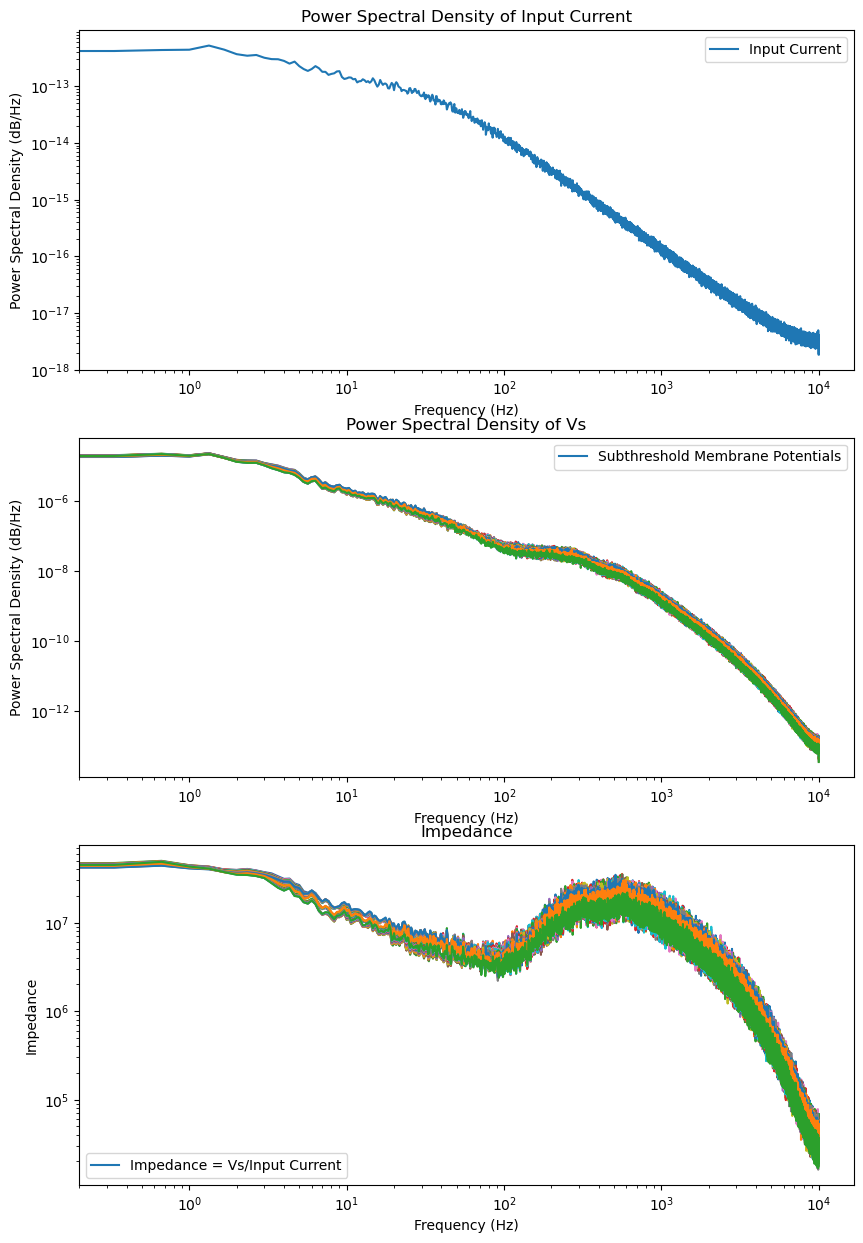

In [24]:
#plot input current all subthreshold membrane potentials and impedence for all gsyn and delay conditions
#if to be used make legend for the plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

#plot input current
ax1.semilogy(frequencies_Is_FN, Pxx_Is_FN[0])
ax1.set_title('Power Spectral Density of Input Current')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Power Spectral Density (dB/Hz)')
ax1.legend(['Input Current'])
ax1.set_xscale('log')
ax1.set_yscale('log')

#plot subthreshold membrane potentials
for i in range(len(Pxx_Vs)):
    ax2.semilogy((frequencies_Vs[i]), Pxx_Vs[i][0])
ax2.set_title('Power Spectral Density of Vs')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Power Spectral Density (dB/Hz)')
ax2.legend(['Subthreshold Membrane Potentials'])
ax2.set_xscale('log')
ax2.set_yscale('log')

#plot impedence
for i in range(len(impedance)):
    ax3.semilogy((frequencies_Vs[i]), impedance[i][0])
ax3.set_title('Impedance')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Impedance')
ax3.legend(['Impedance = Vs/Input Current'])
ax3.set_xscale('log')
ax3.set_yscale('log')


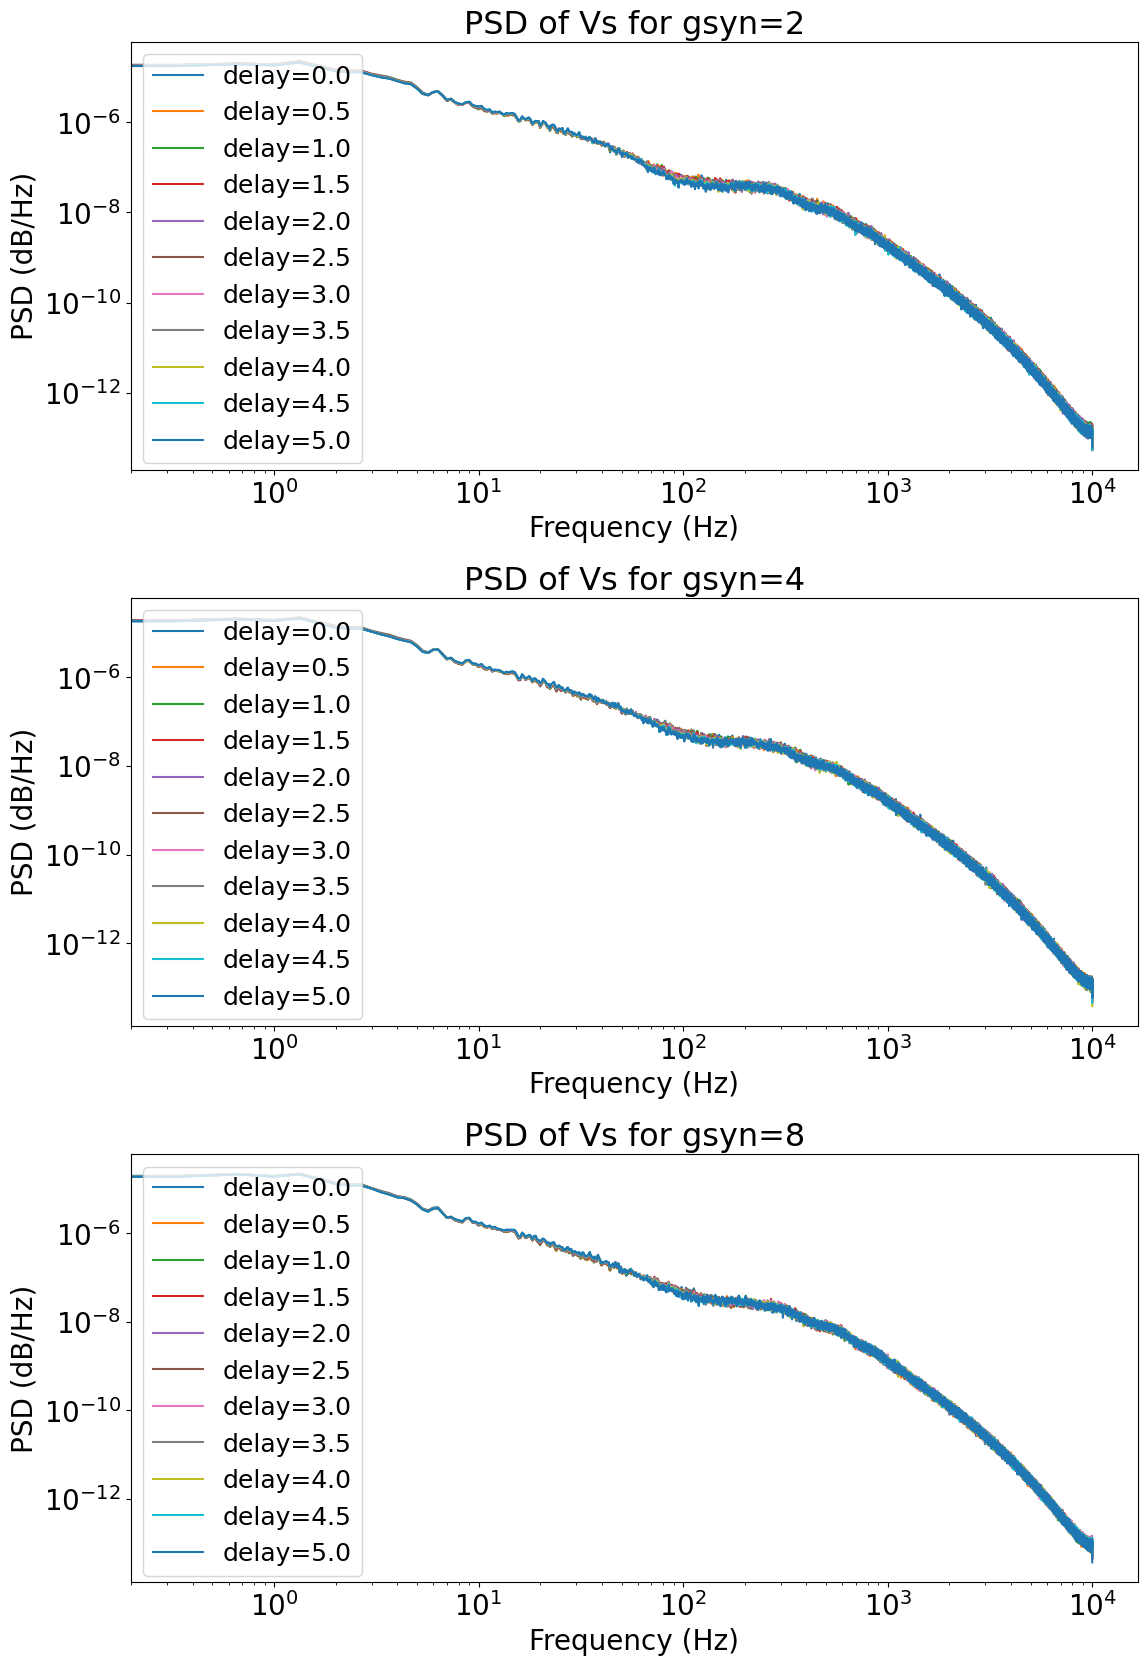

In [25]:
#plot PSD of subthreshold membrane potentials of all gsyn and delay conditions in three plots for all gsyn values and only delay values of 0,1,2,3,4,5
#remember for indexes: the for loop iterates over the range from 0 to 33 with a step size of 3. 
# This means that the loop variable i takes on the values 0, 3, 6, 9, and so on, up to 30.
# for i+1, the loop variable i takes on the values 1, 4, 7, 10, and so on, up to 31 as i starts at 1 and increments by 3.
# for i+2, the loop variable i takes on the values 2, 5, 8, 11, and so on, up to 32 as i starts at 2 and increments by 3.

fig, ax = plt.subplots(3, 1, figsize=(13, 20))
for i in range(0,33,3):
    ax[0].semilogy(frequencies_Vs[i], Pxx_Vs[i][0], label=f'delay={delay_values[i//3]}')
    ax[1].semilogy(frequencies_Vs[i+1], Pxx_Vs[i+1][0], label=f'delay={delay_values[i//3]}')
    ax[2].semilogy(frequencies_Vs[i+2], Pxx_Vs[i+2][0], label=f'delay={delay_values[i//3]}')

ax[0].set_title('PSD of Vs for gsyn=2', fontsize=23)
ax[0].set_xlabel('Frequency (Hz)', fontsize=20)
ax[0].set_ylabel('PSD (dB/Hz)', fontsize=20)
ax[0].legend(fontsize=18)
ax[0].set_xscale('log')
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_yscale('log')

ax[1].set_title('PSD of Vs for gsyn=4', fontsize=23)
ax[1].set_xlabel('Frequency (Hz)', fontsize=20)
ax[1].set_ylabel('PSD (dB/Hz)',fontsize=20)
ax[1].legend(fontsize=18)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].tick_params(axis='both', which='major', labelsize=20)

ax[2].set_title('PSD of Vs for gsyn=8', fontsize=23)
ax[2].set_xlabel('Frequency (Hz)', fontsize=20)
ax[2].set_ylabel('PSD (dB/Hz)', fontsize=20)
ax[2].legend(fontsize=18)
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].tick_params(axis='both', which='major', labelsize=20)
plt.subplots_adjust(hspace=0.3)

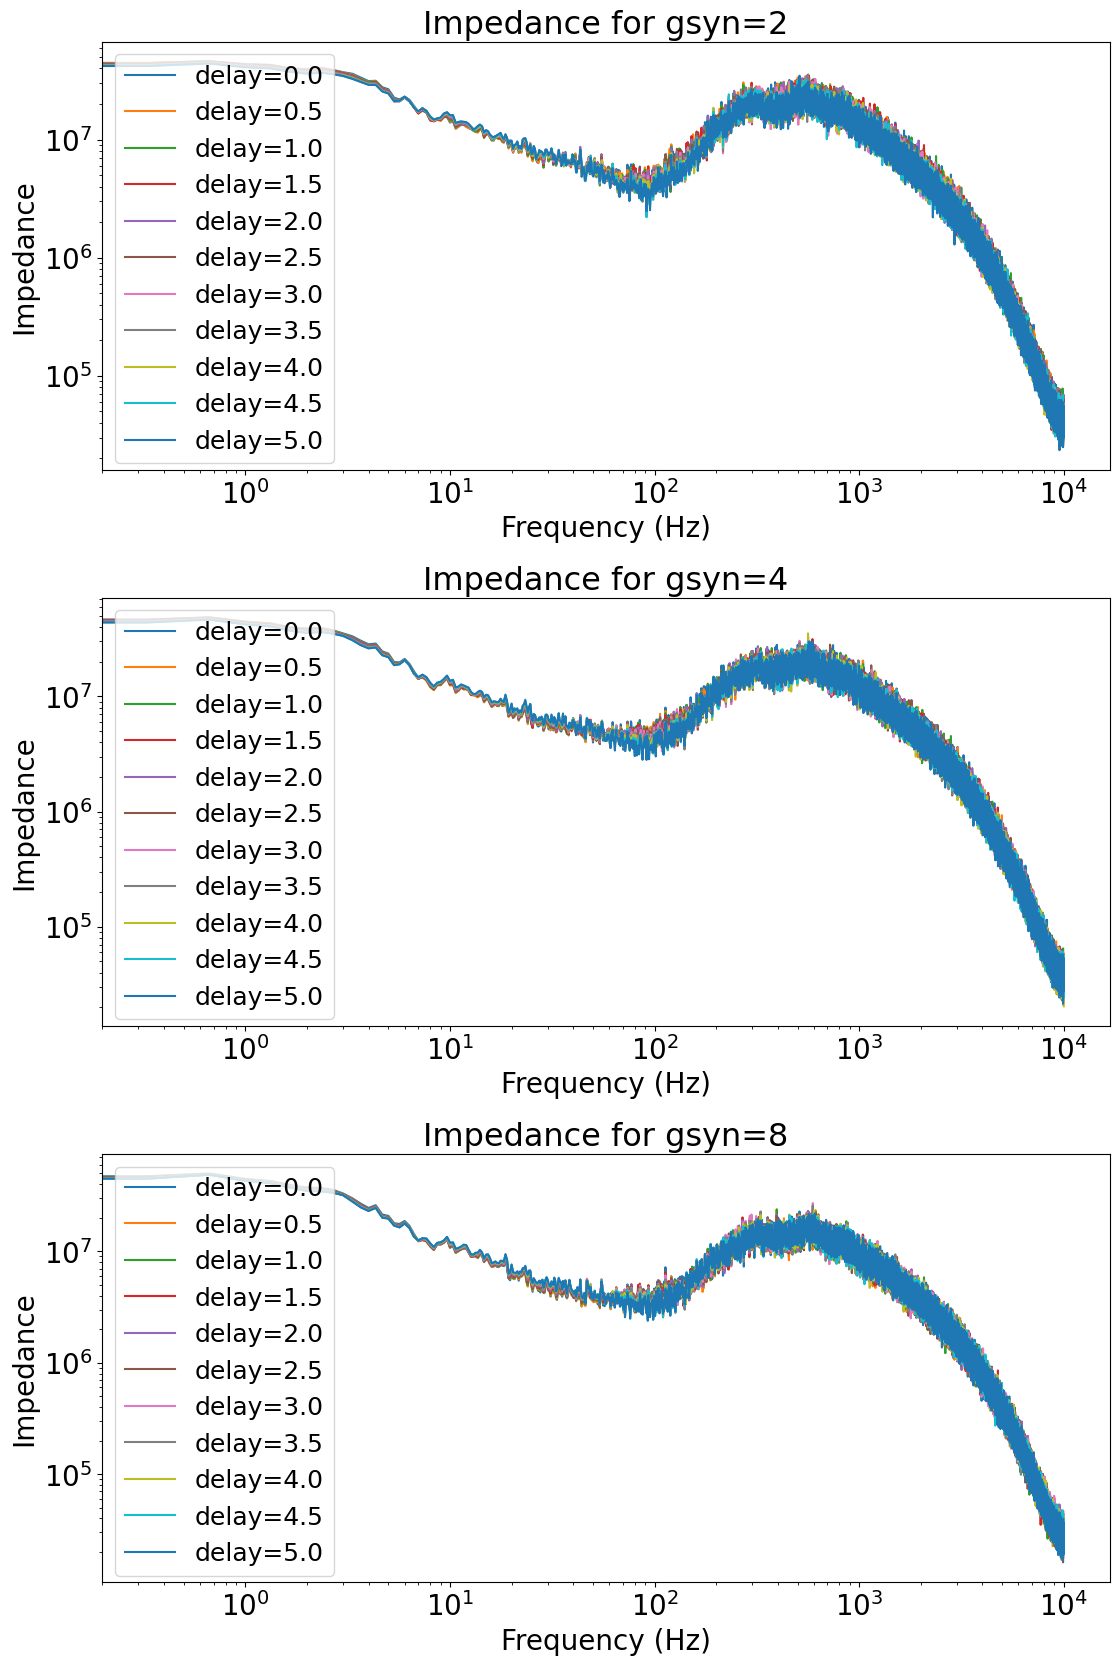

In [26]:
#plot impedence of all gsyn and delay conditions in three plots for all gsyn values and only delay values of 0,1,2,3,4,5
delay_values = np.arange(0,5.5,0.5)
fig, ax = plt.subplots(3, 1, figsize=(13, 20))
for i in range(0,33,3):
    ax[0].semilogy(frequencies_Vs[i], impedance[i][0], label=f'delay={delay_values[i//3]}')
    ax[1].semilogy(frequencies_Vs[i+1], impedance[i+1][0], label=f'delay={delay_values[i//3]}')
    ax[2].semilogy(frequencies_Vs[i+2], impedance[i+2][0], label=f'delay={delay_values[i//3]}')

ax[0].set_title('Impedance for gsyn=2', fontsize=23)
ax[0].set_xlabel('Frequency (Hz)', fontsize=20)
ax[0].set_ylabel('Impedance', fontsize=20)
ax[0].legend(fontsize=18)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_xscale('log')
# ax[0].set_yscale('log')

ax[1].set_title('Impedance for gsyn=4', fontsize=23)
ax[1].set_xlabel('Frequency (Hz)', fontsize=20)
ax[1].set_ylabel('Impedance', fontsize=20)
ax[1].legend(fontsize=18)
ax[1].set_xscale('log')
ax[1].tick_params(axis='both', which='major', labelsize=20)
# ax[1].set_yscale('log')

ax[2].set_title('Impedance for gsyn=8', fontsize=23)
ax[2].set_xlabel('Frequency (Hz)', fontsize=20)
ax[2].set_ylabel('Impedance', fontsize=20)
ax[2].legend(fontsize=18)
ax[2].set_xscale('log')
ax[2].tick_params(axis='both', which='major', labelsize=20)
# ax[2].set_yscale('log')
plt.subplots_adjust(hspace=0.3)

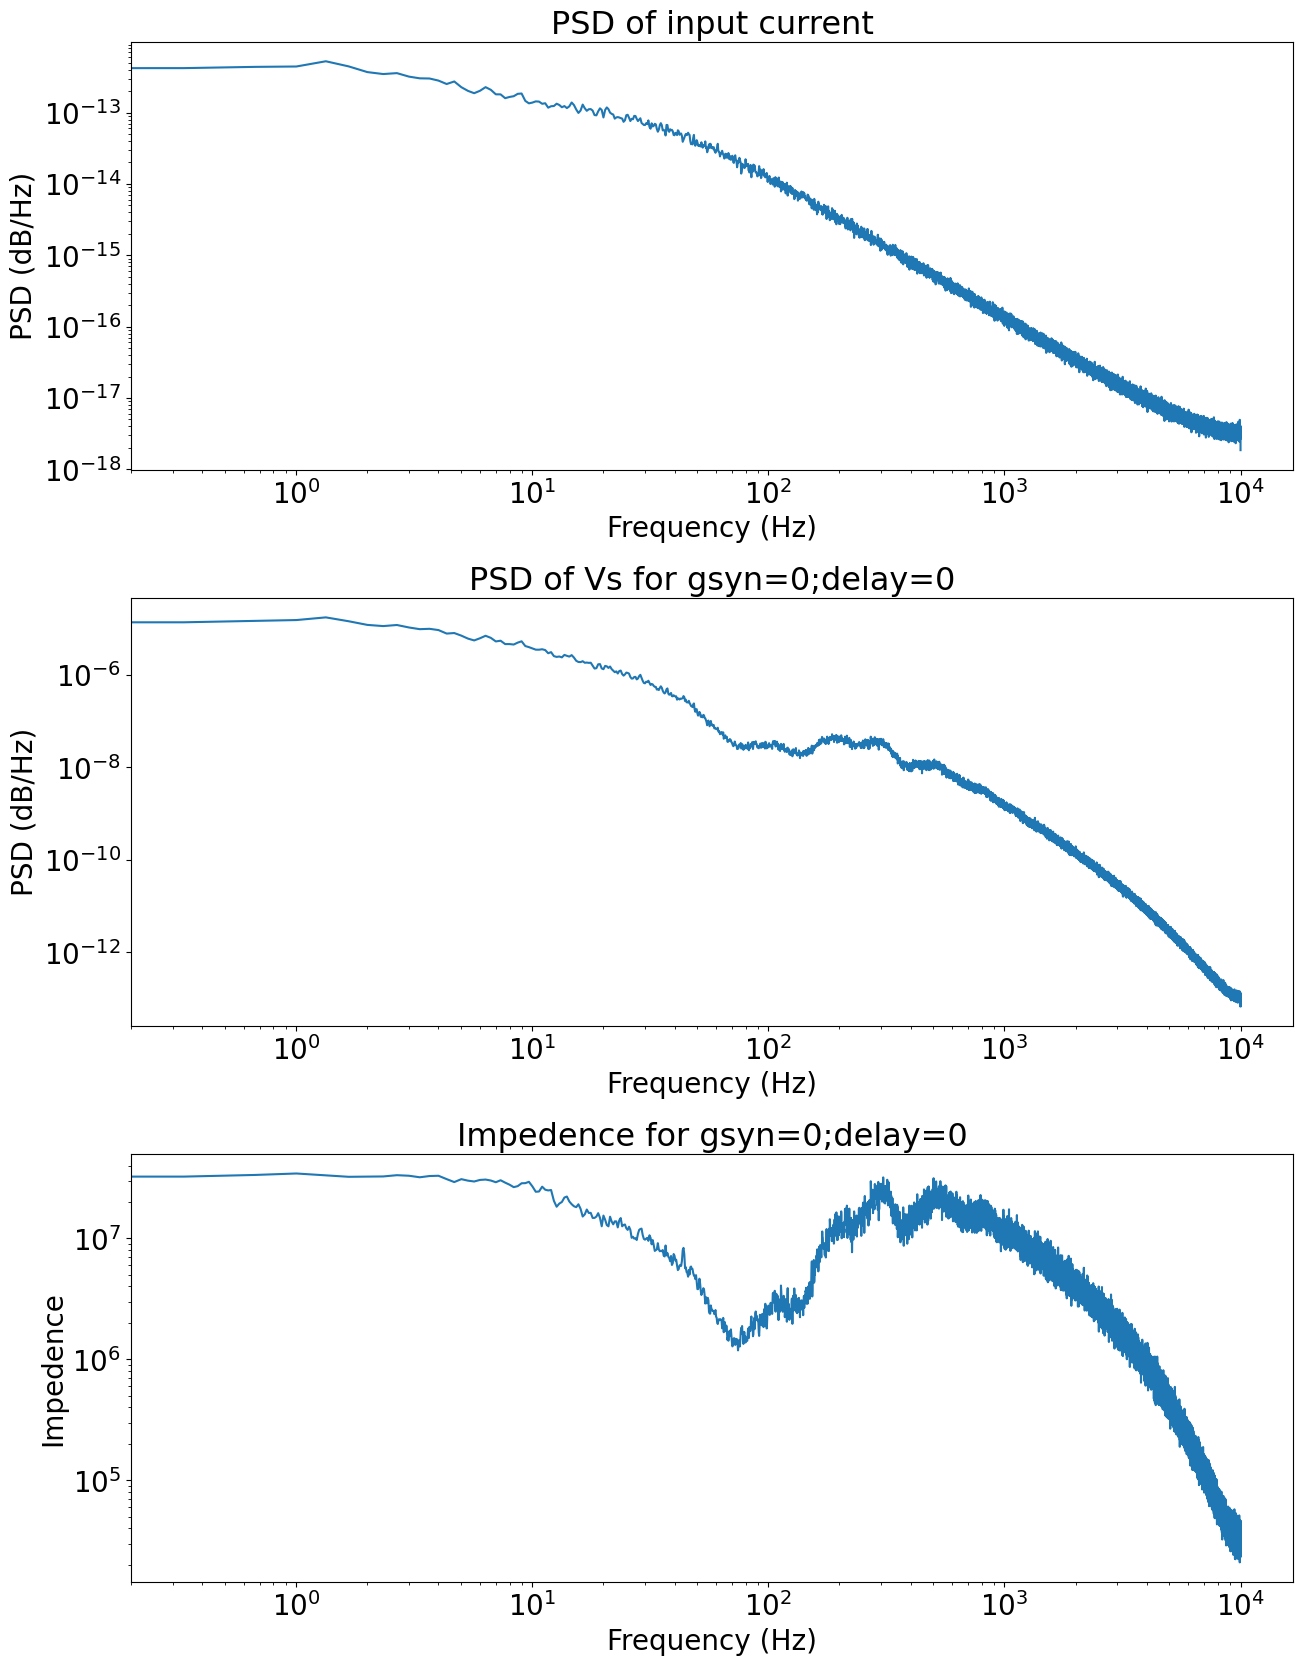

In [27]:
control_with_no_synapse = sio.loadmat("D:\\Internship2\\feedforward_sims\\output.mat")

#calculate PSD of subthreshold membrane potential and input current for control with no synapse
Vs = control_with_no_synapse['Pyr_Vs']
Is_FN = control_with_no_synapse['Pyr_Is_FN']

# Sub-threshold voltage processing
Vs_sub = Vs.copy()
Vs_sub[Vs_sub < -20] = np.nan

# Set up figure
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20))

# Calculate and plot PSD using Welch's method with shorter windows
frequencies_Vs, Pxx_Vs = signal.welch(Vs_sub, fs=fs, nperseg=nperseg, scaling='density')
frequencies_Is_FN, Pxx_Is_FN = signal.welch(Is_FN, fs=fs, nperseg=nperseg, scaling='density')
impedence = Pxx_Vs / Pxx_Is_FN

# Plot results
ax1.semilogy(frequencies_Is_FN, Pxx_Is_FN[0])
ax1.set_title('PSD of input current', fontsize=23)
ax1.set_xlabel('Frequency (Hz)', fontsize=20)
ax1.set_ylabel('PSD (dB/Hz)', fontsize=20)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.tick_params(axis='both', which='major', labelsize=20)

ax2.semilogy(frequencies_Vs, Pxx_Vs[0])
ax2.set_title('PSD of Vs for gsyn=0;delay=0', fontsize=23)
ax2.set_xlabel('Frequency (Hz)', fontsize=20)
ax2.set_ylabel('PSD (dB/Hz)', fontsize=20)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.tick_params(axis='both', which='major', labelsize=20)

ax3.semilogy(frequencies_Vs, impedence[0])
ax3.set_title('Impedence for gsyn=0;delay=0',fontsize=23)
ax3.set_xlabel('Frequency (Hz)', fontsize=20)
ax3.set_ylabel('Impedence', fontsize=20)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.tick_params(axis='both', which='major', labelsize=20)
plt.subplots_adjust(hspace=0.3)


In [28]:
#making binary spike trains for all gsyn and delay conditions for correlation analysis
hidden_state = sio.loadmat("D:\\Internship2\\feedforward_sims\\input_inhibitory_tau_50_sampling_20_kHz.mat")["hidden_state_i"]
hidden_state = hidden_state[:int(total_time/dt)]
hidden_state = np.squeeze(hidden_state)

gsyn8=[]
gsyn4=[]
gsyn2=[]
# Extract delay values for gsyn 8
for file_set in [control_files[2], delay_files[2], delay_files[5], delay_files[8], 
                delay_files[11], delay_files[14], delay_files[17], delay_files[20], 
                delay_files[23], delay_files[26], delay_files[29]]:
    binary_spikes = np.zeros(int(total_time / dt))
    for spike_time in file_set['S_pyr_spikes'][0]:
        binary_spikes[int(spike_time / dt)] = 1
    gsyn8.append(binary_spikes.copy())

# Extract delay values for gsyn 4
for file_set in [control_files[1], delay_files[1], delay_files[4], delay_files[7],
                delay_files[10], delay_files[13], delay_files[16], delay_files[19],
                delay_files[22], delay_files[25], delay_files[28]]:
    binary_spikes = np.zeros(int(total_time / dt))
    for spike_time in file_set['S_pyr_spikes'][0]:
        binary_spikes[int(spike_time / dt)] = 1
    gsyn4.append(binary_spikes.copy())

# Extract delay values for gsyn 2
for file_set in [control_files[0], delay_files[0], delay_files[3], delay_files[6],
                delay_files[9], delay_files[12], delay_files[15], delay_files[18],
                delay_files[21], delay_files[24], delay_files[27]]:
    binary_spikes = np.zeros(int(total_time / dt))
    for spike_time in file_set['S_pyr_spikes'][0]:
        binary_spikes[int(spike_time / dt)] = 1
    gsyn2.append(binary_spikes.copy())

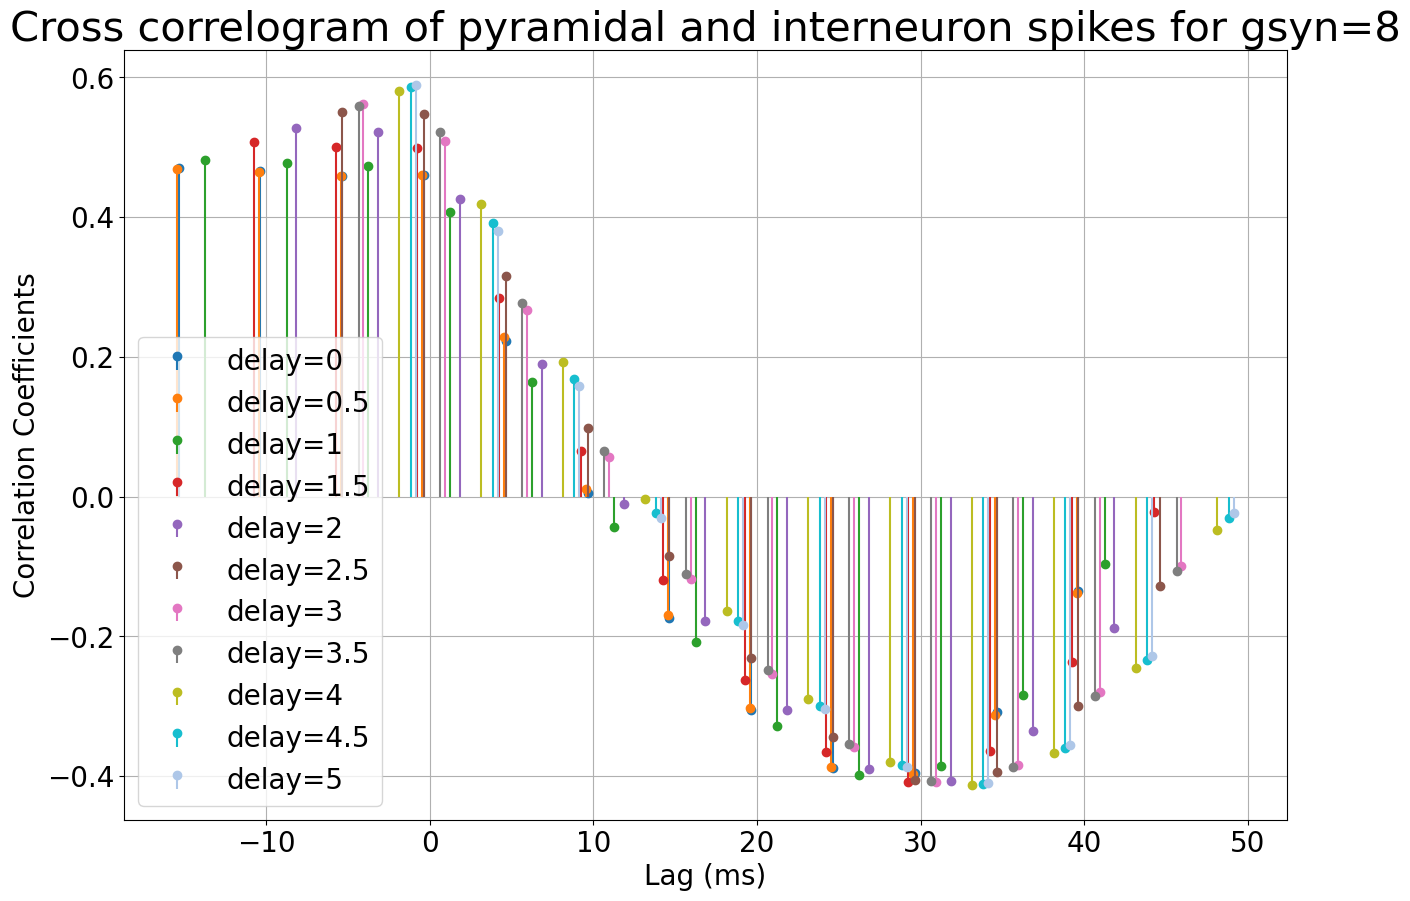

In [29]:
#extract spike times of interneurons
interneuron_spikes = []
interneuron_spikes.append(control_files[2]['S_int_spikes'][0])
for i in range(2,30,3):
    interneuron_spikes.append(delay_files[i]['S_int_spikes'][0])
# interneuron_spikes = interneuron_spikes*11
#Extract spike times of pyramidal neurons for gsyn2
pyramidal_spikes = []
pyramidal_spikes.append(control_files[2]['S_pyr_spikes'][0])
#for delay files get only the following indexes:2,5,8,11,14,17,20,23,26,29
for i in range(2,30,3):
    pyramidal_spikes.append(delay_files[i]['S_pyr_spikes'][0])

#plot color cross correlogram of spikes of pyramidal neuron and interneuron for gsyn=2 and all delays
fig, ax = plt.subplots(figsize=(15,10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8']
for i in range(11):
    color_plot_correlations(pyramidal_spikes[i], interneuron_spikes[i], 50, 'Pyramidal spikes', 'Interneuron spikes for gsyn = 8', ax, color = colors[i])
    ax.set_title('Cross correlogram of pyramidal and interneuron spikes for gsyn=8', fontsize=30)
    plt.legend([f'delay=0','delay=0.5', 'delay=1', 'delay=1.5', 'delay=2', 'delay=2.5', 'delay=3', 'delay=3.5', 'delay=4', 'delay=4.5', 'delay=5'], fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Lag (ms)', fontsize=20)
    plt.ylabel('Correlation Coefficients', fontsize=20)
plt.show()


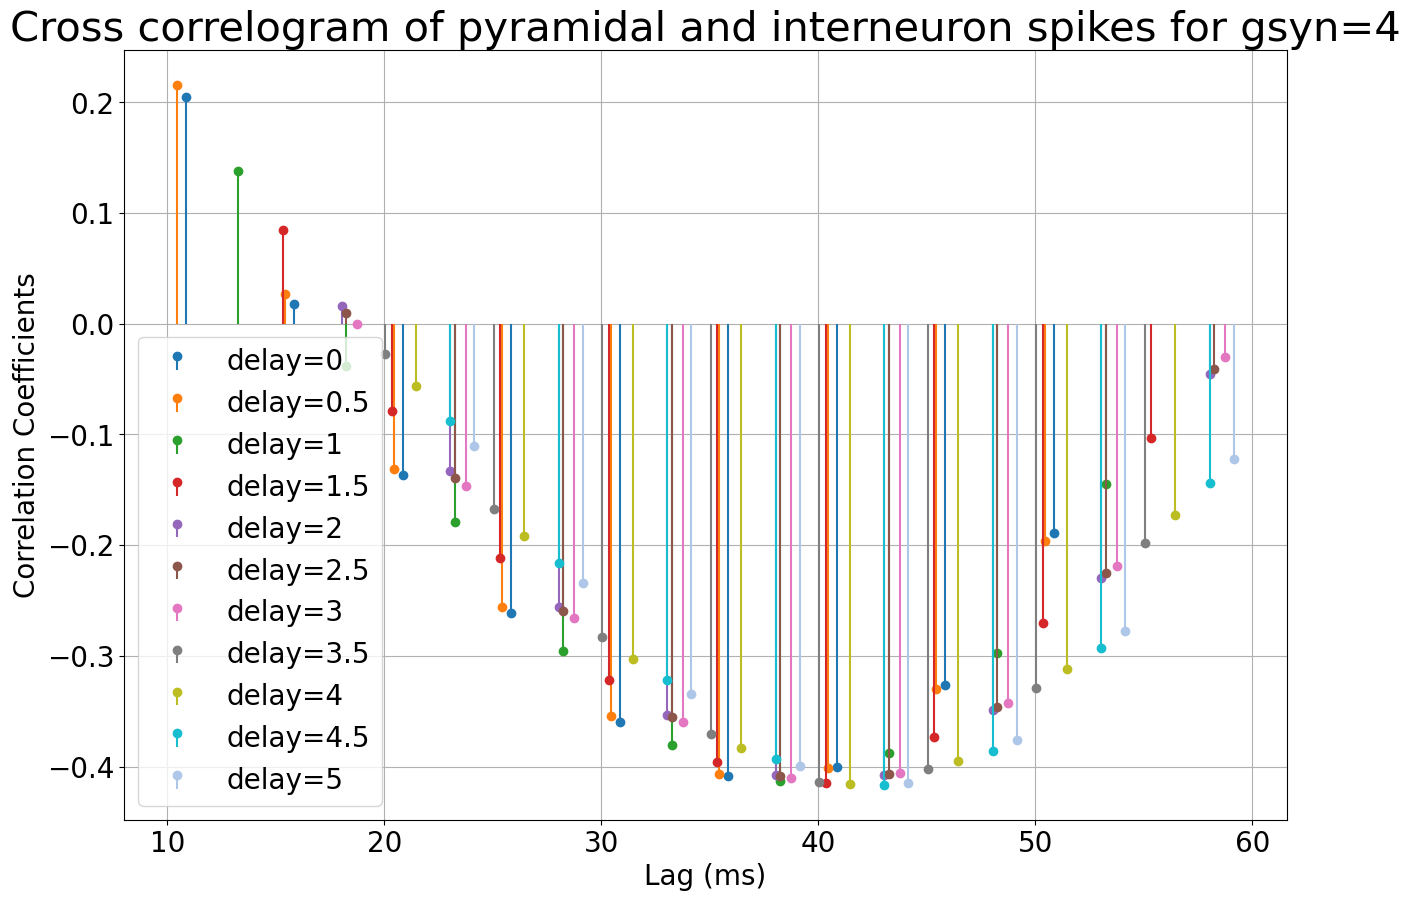

In [30]:
#extract spike times of interneurons
interneuron_spikes = []
interneuron_spikes.append(control_files[1]['S_int_spikes'][0])
for i in range(1,30,3):
    interneuron_spikes.append(delay_files[i]['S_int_spikes'][0])
# interneuron_spikes = interneuron_spikes*11
#Extract spike times of pyramidal neurons for gsyn2
pyramidal_spikes = []
pyramidal_spikes.append(control_files[1]['S_pyr_spikes'][0])
#for delay files get only the following indexes: 1,4,7,10,13,16,19,22,25,28
for i in range(1,30,3):
    pyramidal_spikes.append(delay_files[i]['S_pyr_spikes'][0])

#plot color cross correlogram of spikes of pyramidal neuron and interneuron for gsyn=2 and all delays
fig, ax = plt.subplots(figsize=(15,10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8']
for i in range(11):
    color_plot_correlations(pyramidal_spikes[i], interneuron_spikes[i], 50, 'Pyr spikes', 'Int spikes for gsyn = 4', ax, color = colors[i])
    ax.set_title('Cross correlogram of pyramidal and interneuron spikes for gsyn=4', fontsize=30)
    plt.legend([f'delay=0','delay=0.5', 'delay=1', 'delay=1.5', 'delay=2', 'delay=2.5', 'delay=3', 'delay=3.5', 'delay=4', 'delay=4.5', 'delay=5'], fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Lag (ms)', fontsize=20)
    plt.ylabel('Correlation Coefficients', fontsize=20)
plt.show()


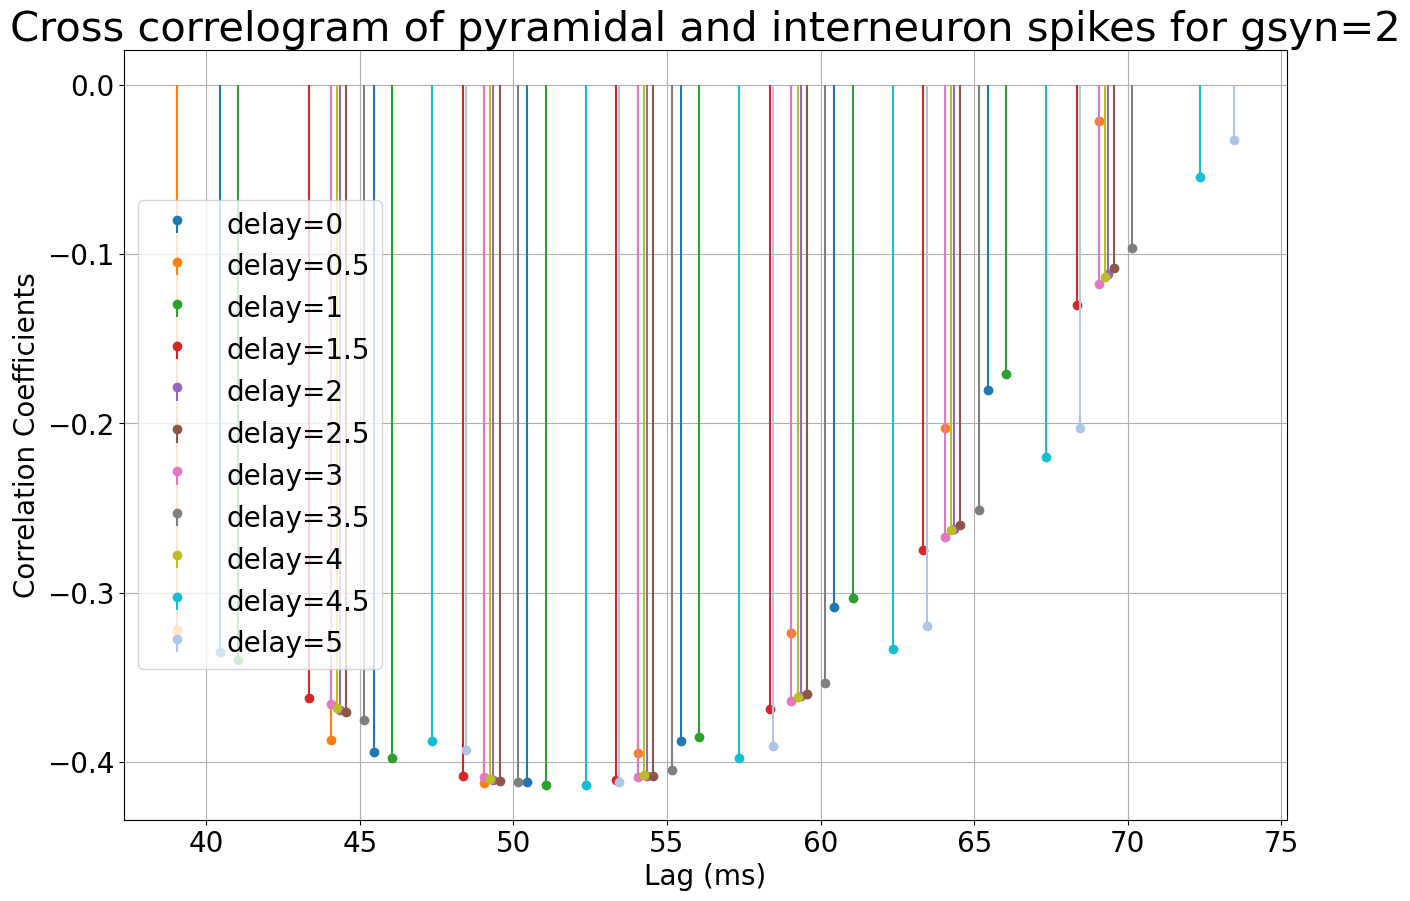

In [31]:
#extract spike times of interneurons
interneuron_spikes = []
interneuron_spikes.append(control_files[0]['S_int_spikes'][0])
for i in range(0,30,3):
    interneuron_spikes.append(delay_files[i]['S_int_spikes'][0])
    
#Extract spike times of pyramidal neurons for gsyn2
pyramidal_spikes = []
pyramidal_spikes.append(control_files[0]['S_pyr_spikes'][0])
#for delay files get only the following indexes: 0,3,6,9,12,15,18,21,24,27
for i in range(0,30,3):
    pyramidal_spikes.append(delay_files[i]['S_pyr_spikes'][0])
#plot color cross correlogram of spikes of pyramidal neuron and interneuron for gsyn=2 and all delays
fig, ax = plt.subplots(figsize=(15,10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8']
for i in range(11):
    color_plot_correlations(pyramidal_spikes[i], interneuron_spikes[i], 50, 'Pyr spikes', 'Int spikes for gsyn = 2', ax, color = colors[i])
    ax.set_title('Cross correlogram of pyramidal and interneuron spikes for gsyn=2', fontsize=30)
    plt.legend([f'delay=0','delay=0.5', 'delay=1', 'delay=1.5', 'delay=2', 'delay=2.5', 'delay=3', 'delay=3.5', 'delay=4', 'delay=4.5', 'delay=5'], fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Lag (ms)', fontsize=20)
    plt.ylabel('Correlation Coefficients', fontsize=20)
plt.show()

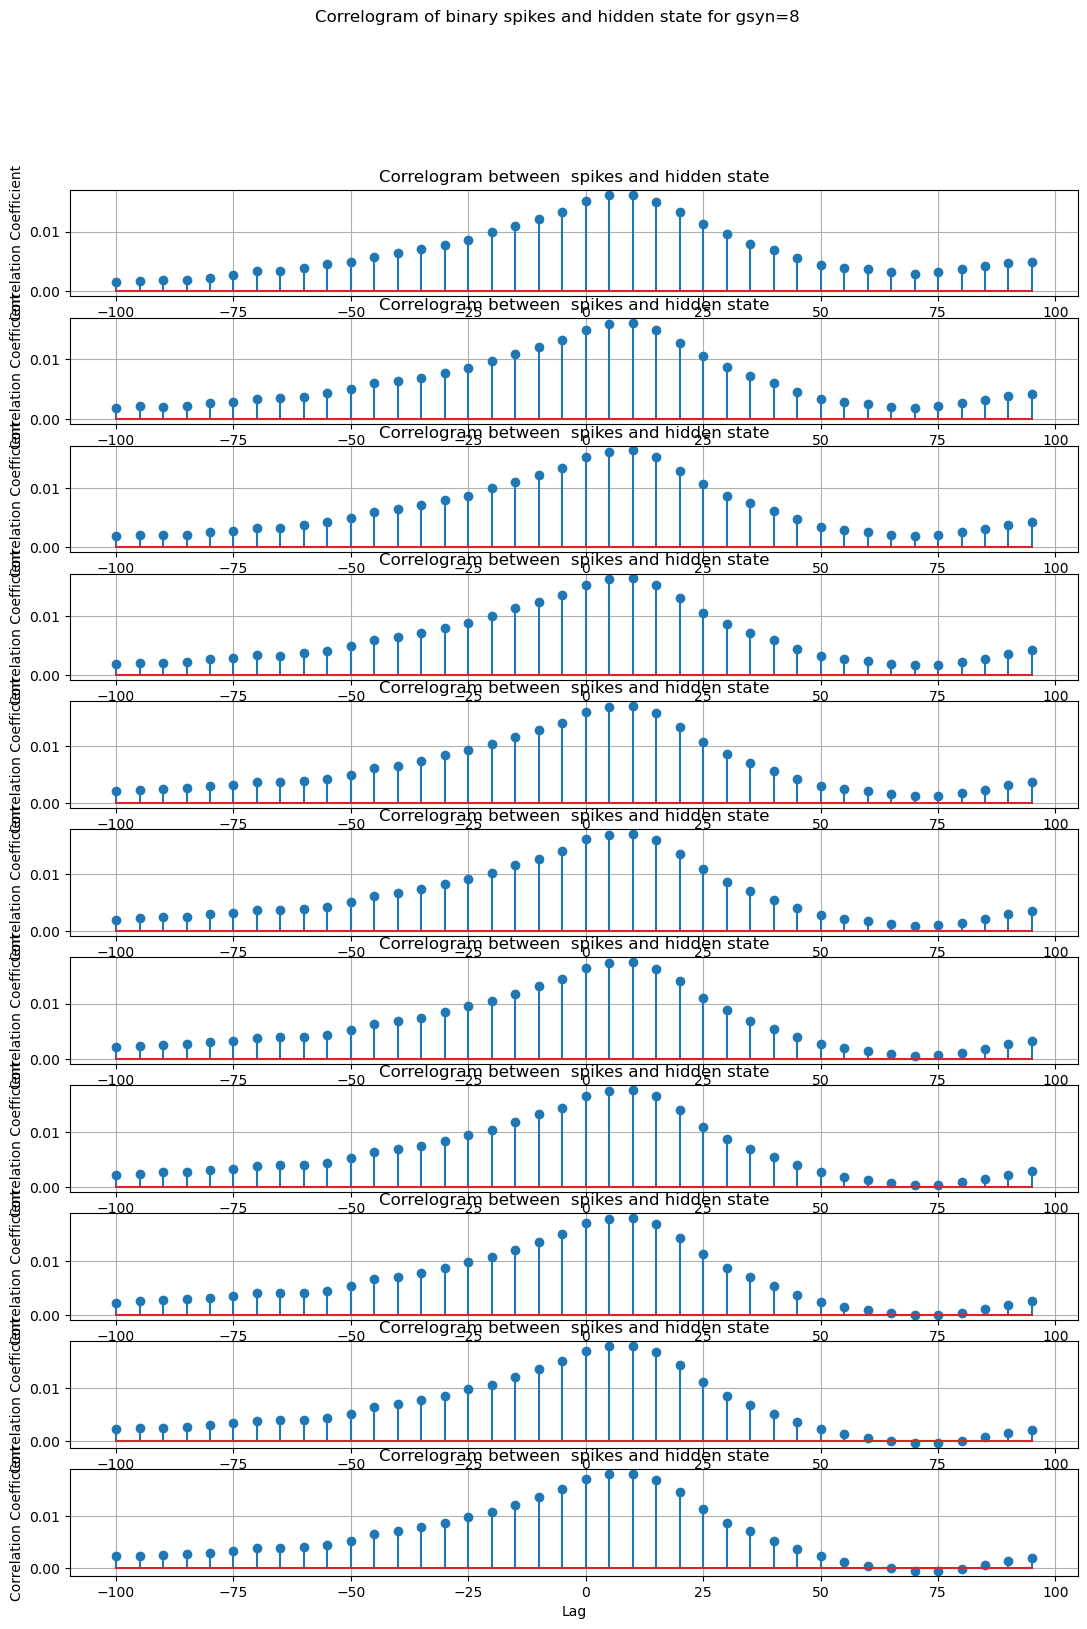

In [32]:
fig,ax = plt.subplots(11,1,figsize=(13,18))
plt.suptitle('Correlogram of binary spikes and hidden state for gsyn=8')
plot_correlations(gsyn8[0], hidden_state, 50, ' spikes', 'hidden state', ax[0])
plot_correlations(gsyn8[1], hidden_state, 50, ' spikes', 'hidden state', ax[1])
plot_correlations(gsyn8[2], hidden_state, 50, ' spikes', 'hidden state', ax[2])
plot_correlations(gsyn8[3], hidden_state, 50, ' spikes', 'hidden state', ax[3])
plot_correlations(gsyn8[4], hidden_state, 50, ' spikes', 'hidden state', ax[4])
plot_correlations(gsyn8[5], hidden_state, 50, ' spikes', 'hidden state', ax[5])
plot_correlations(gsyn8[6], hidden_state, 50, ' spikes', 'hidden state', ax[6])
plot_correlations(gsyn8[7], hidden_state, 50, ' spikes', 'hidden state', ax[7])
plot_correlations(gsyn8[8], hidden_state, 50, ' spikes', 'hidden state', ax[8])
plot_correlations(gsyn8[9], hidden_state, 50, ' spikes', 'hidden state', ax[9])
plot_correlations(gsyn8[10], hidden_state, 50, ' spikes', 'hidden state', ax[10])

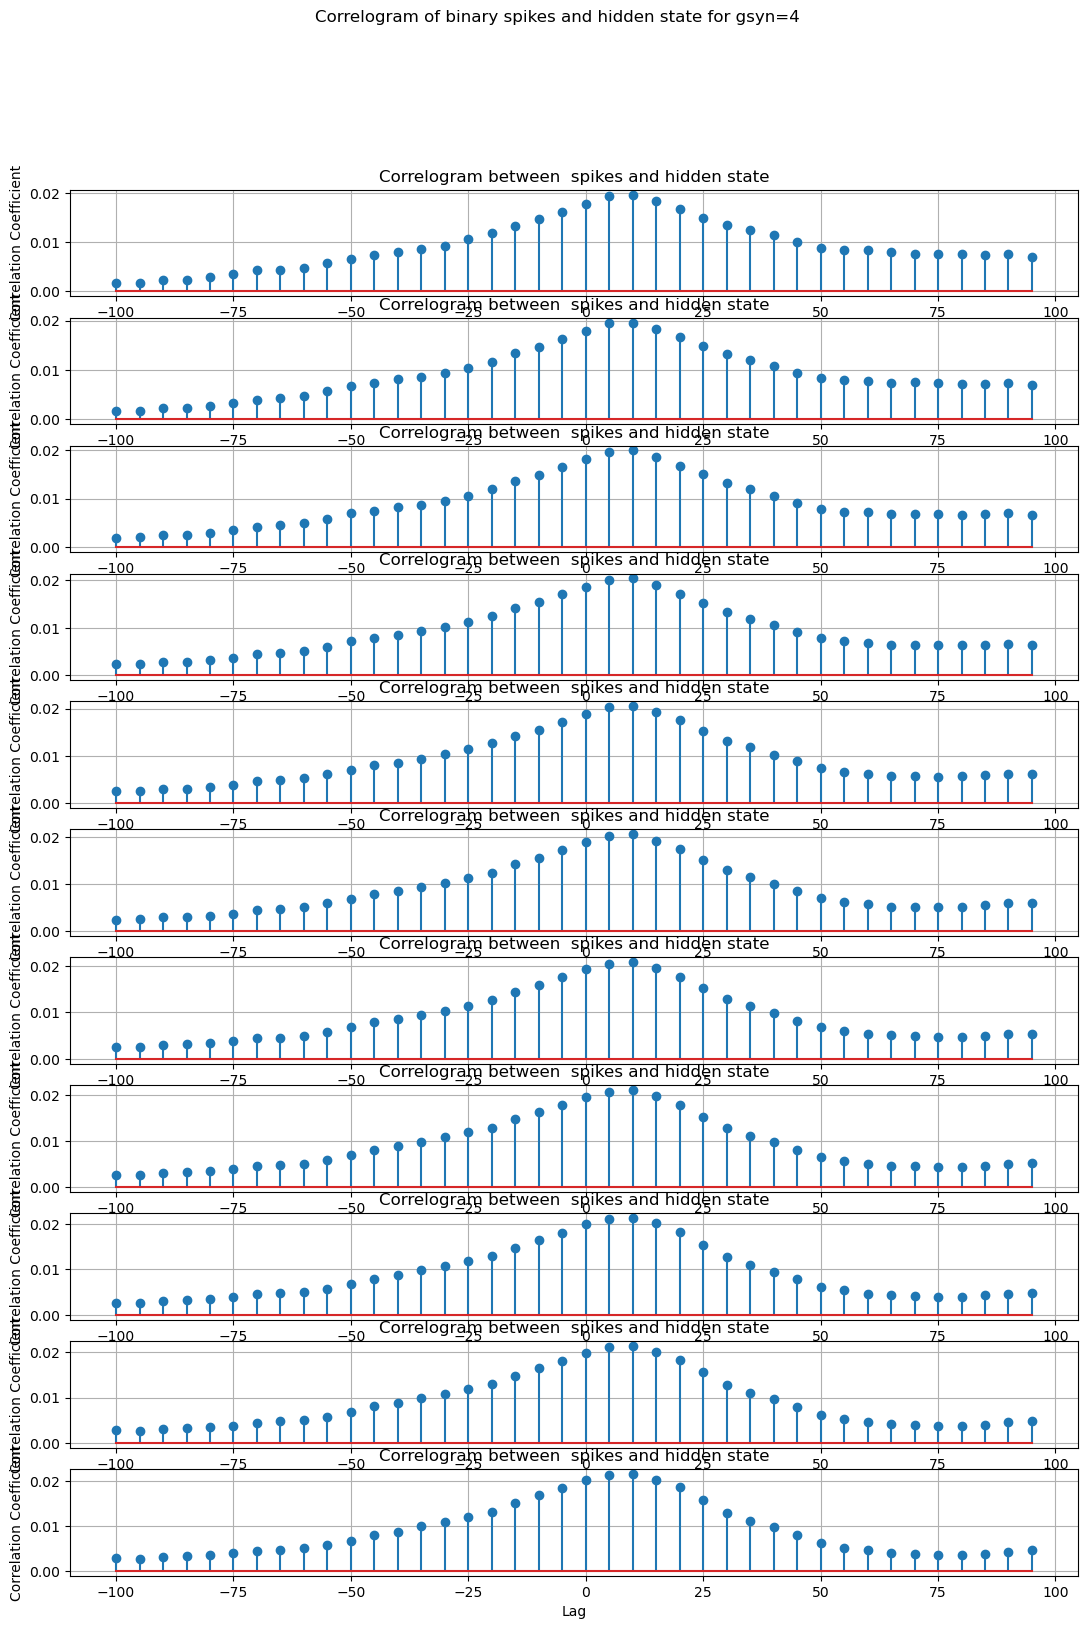

In [33]:
fig,ax = plt.subplots(11,1,figsize=(13,18))
#set plot title
plt.suptitle('Correlogram of binary spikes and hidden state for gsyn=4')
plot_correlations(gsyn4[0], hidden_state, 50, ' spikes', 'hidden state', ax[0])
plot_correlations(gsyn4[1], hidden_state, 50, ' spikes', 'hidden state', ax[1])
plot_correlations(gsyn4[2], hidden_state, 50, ' spikes', 'hidden state', ax[2])
plot_correlations(gsyn4[3], hidden_state, 50, ' spikes', 'hidden state', ax[3])
plot_correlations(gsyn4[4], hidden_state, 50, ' spikes', 'hidden state', ax[4])
plot_correlations(gsyn4[5], hidden_state, 50, ' spikes', 'hidden state', ax[5])
plot_correlations(gsyn4[6], hidden_state, 50, ' spikes', 'hidden state', ax[6])
plot_correlations(gsyn4[7], hidden_state, 50, ' spikes', 'hidden state', ax[7])
plot_correlations(gsyn4[8], hidden_state, 50, ' spikes', 'hidden state', ax[8])
plot_correlations(gsyn4[9], hidden_state, 50, ' spikes', 'hidden state', ax[9])
plot_correlations(gsyn4[10], hidden_state, 50, ' spikes', 'hidden state', ax[10])

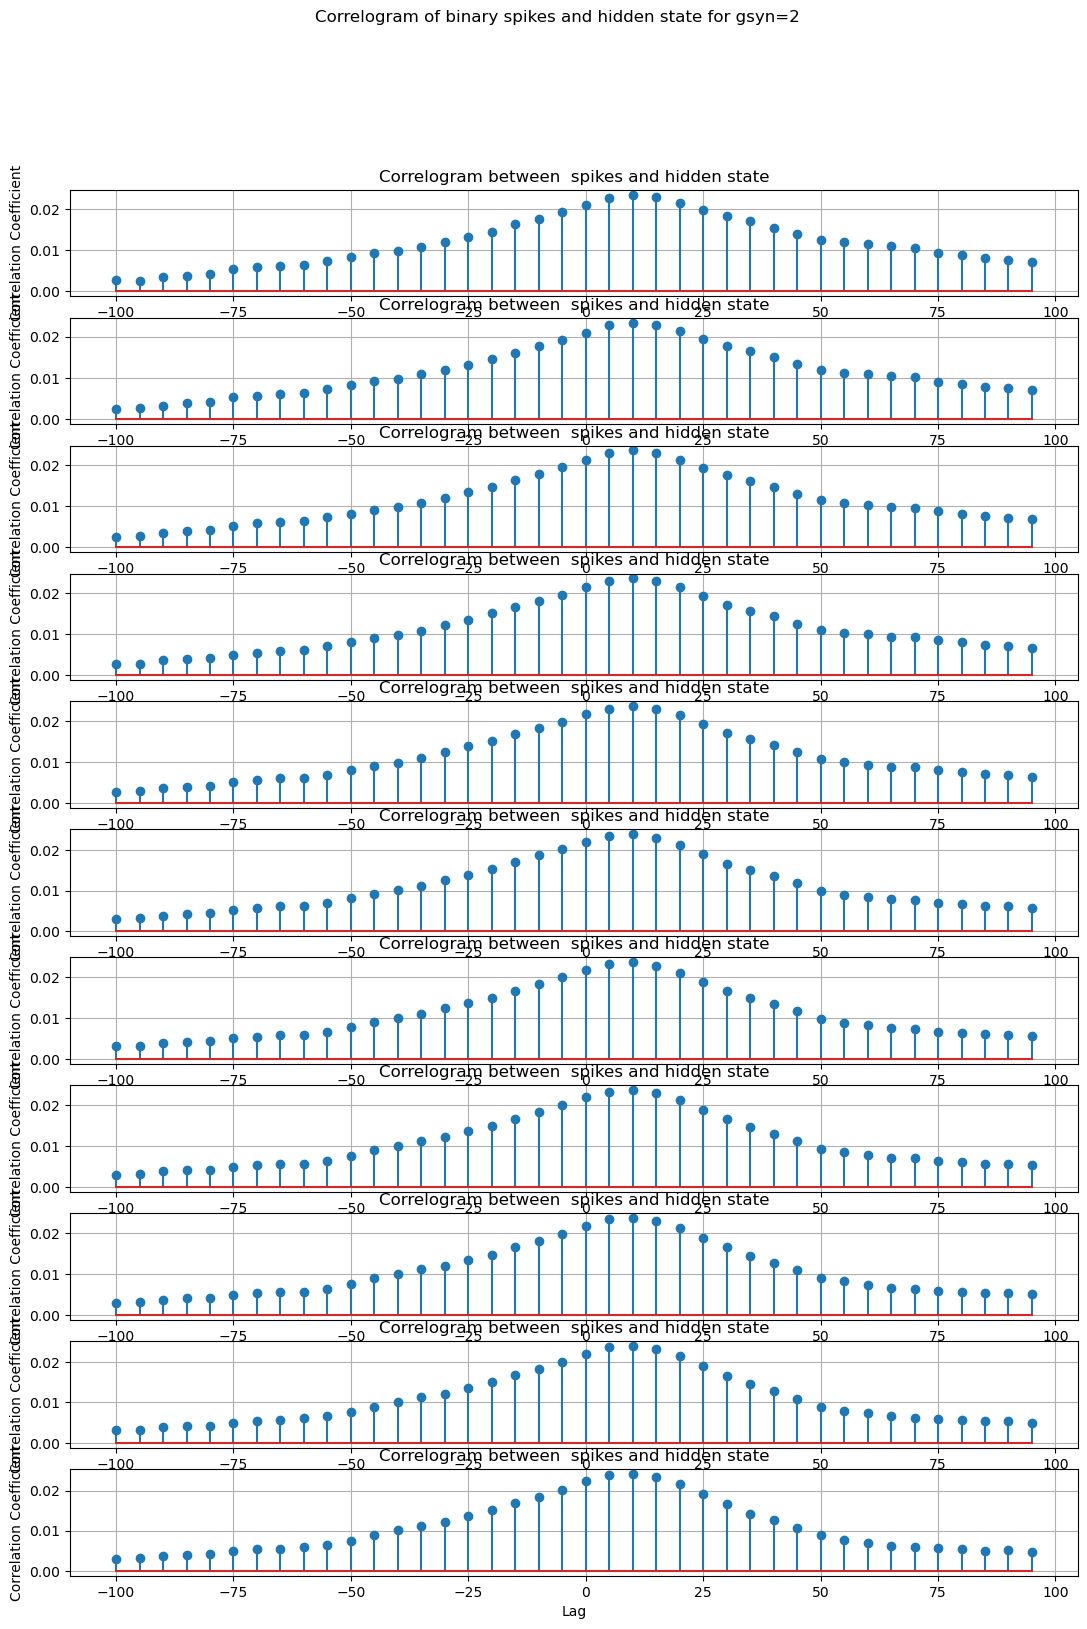

In [34]:
fig,ax = plt.subplots(11,1,figsize=(13,18))
plt.suptitle('Correlogram of binary spikes and hidden state for gsyn=2')
plot_correlations(gsyn2[0], hidden_state, 50, ' spikes', 'hidden state', ax[0])
plot_correlations(gsyn2[1], hidden_state, 50, ' spikes', 'hidden state', ax[1])
plot_correlations(gsyn2[2], hidden_state, 50, ' spikes', 'hidden state', ax[2])
plot_correlations(gsyn2[3], hidden_state, 50, ' spikes', 'hidden state', ax[3])
plot_correlations(gsyn2[4], hidden_state, 50, ' spikes', 'hidden state', ax[4])
plot_correlations(gsyn2[5], hidden_state, 50, ' spikes', 'hidden state', ax[5])
plot_correlations(gsyn2[6], hidden_state, 50, ' spikes', 'hidden state', ax[6])
plot_correlations(gsyn2[7], hidden_state, 50, ' spikes', 'hidden state', ax[7])
plot_correlations(gsyn2[8], hidden_state, 50, ' spikes', 'hidden state', ax[8])
plot_correlations(gsyn2[9], hidden_state, 50, ' spikes', 'hidden state', ax[9])
plot_correlations(gsyn2[10], hidden_state, 50, ' spikes', 'hidden state', ax[10])

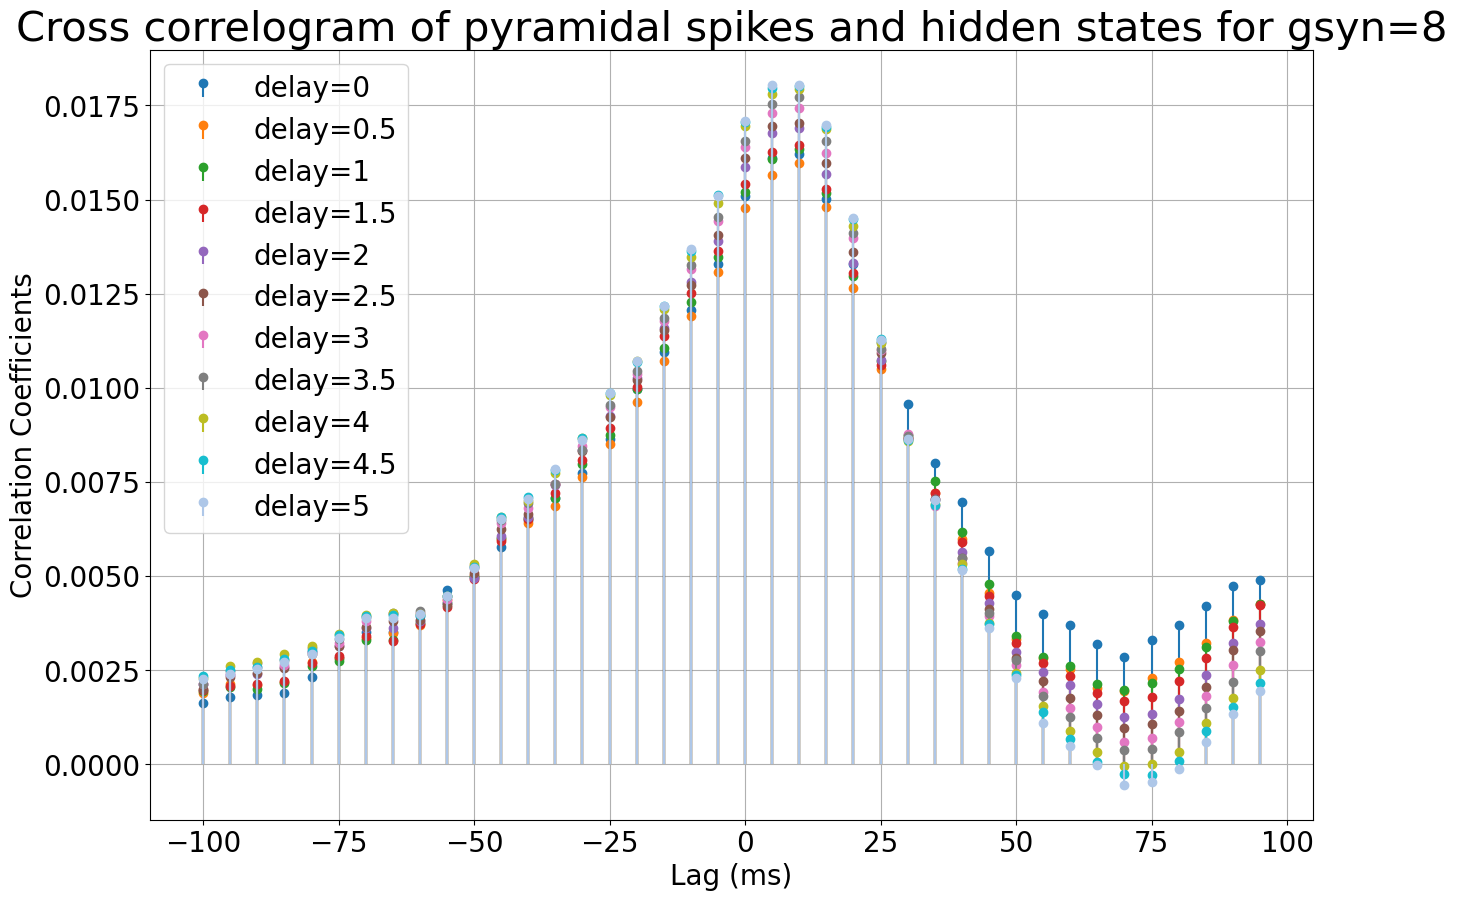

In [35]:
fig, ax = plt.subplots(figsize = (15,10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8']
for i in range(11):
    #increase marker size to 10
    color_plot_correlations(gsyn8[i], hidden_state, 50, ' spikes', 'hidden state', ax, color = colors[i])
    ax.set_title('Cross correlogram of pyramidal spikes and hidden states for gsyn=8', fontsize=30)
    plt.legend([f'delay=0','delay=0.5', 'delay=1', 'delay=1.5', 'delay=2', 'delay=2.5', 'delay=3', 'delay=3.5', 'delay=4', 'delay=4.5', 'delay=5'], 
    fontsize=20, loc='upper left')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Lag (ms)', fontsize=20)
    plt.ylabel('Correlation Coefficients', fontsize=20)
plt.show()

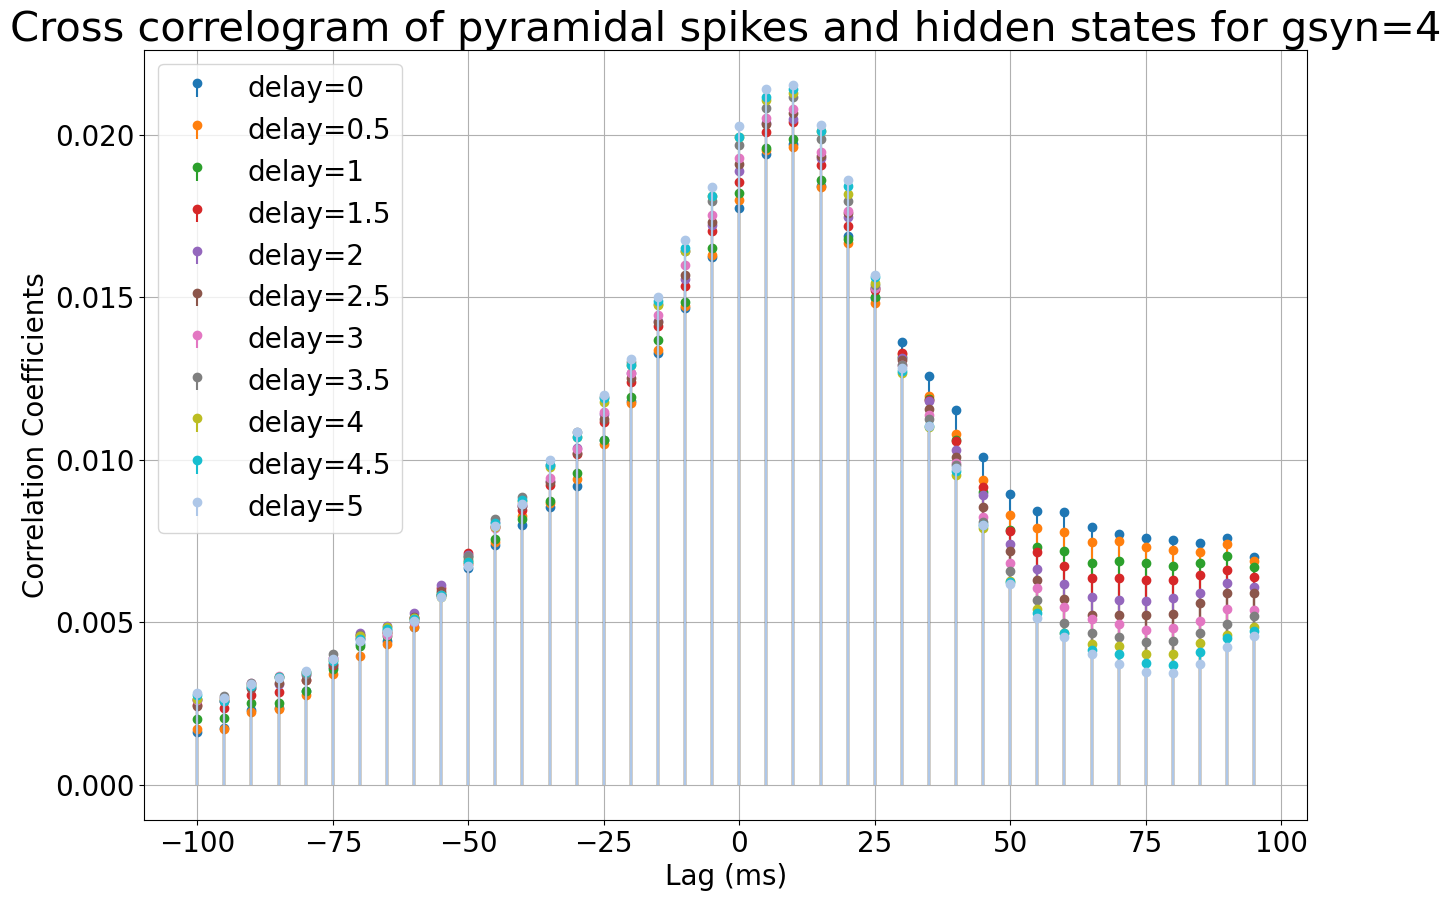

In [36]:
fig, ax = plt.subplots(figsize = (15,10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8']
for i in range(11):
    color_plot_correlations(gsyn4[i], hidden_state, 50, 'spikes', 'hidden state for gsyn = 4', ax, color=colors[i])
    ax.set_title('Cross correlogram of pyramidal spikes and hidden states for gsyn=4', fontsize=30)
    plt.legend([f'delay=0','delay=0.5', 'delay=1', 'delay=1.5', 'delay=2', 'delay=2.5', 'delay=3', 'delay=3.5', 'delay=4', 'delay=4.5', 'delay=5'], fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Lag (ms)', fontsize=20)
    plt.ylabel('Correlation Coefficients', fontsize=20)
plt.show()

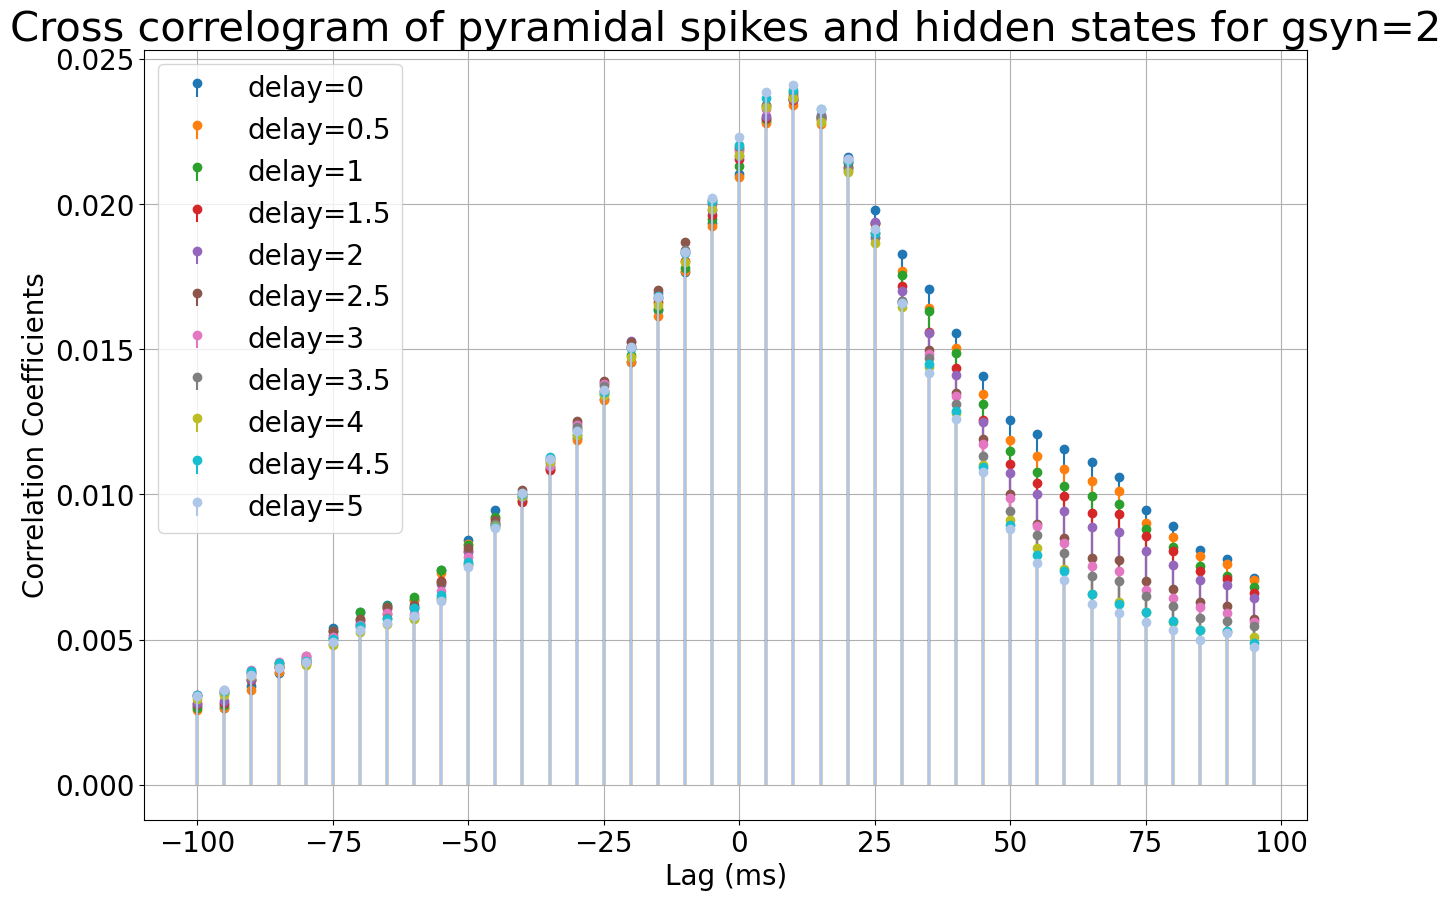

In [37]:
fig, ax = plt.subplots(figsize = (15,10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8']
for i in range(11):
    color_plot_correlations(gsyn2[i], hidden_state, 50, 'spikes', 'hidden state for gsyn = 2', ax, color=colors[i])
    ax.set_title('Cross correlogram of pyramidal spikes and hidden states for gsyn=2', fontsize=30)
    plt.legend([f'delay=0','delay=0.5', 'delay=1', 'delay=1.5', 'delay=2', 'delay=2.5', 'delay=3', 'delay=3.5', 'delay=4', 'delay=4.5', 'delay=5'], fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Lag (ms)', fontsize=20)
    plt.ylabel('Correlation Coefficients', fontsize=20)
plt.show()

Text(0, 0.5, 'Correlation Coefficients')

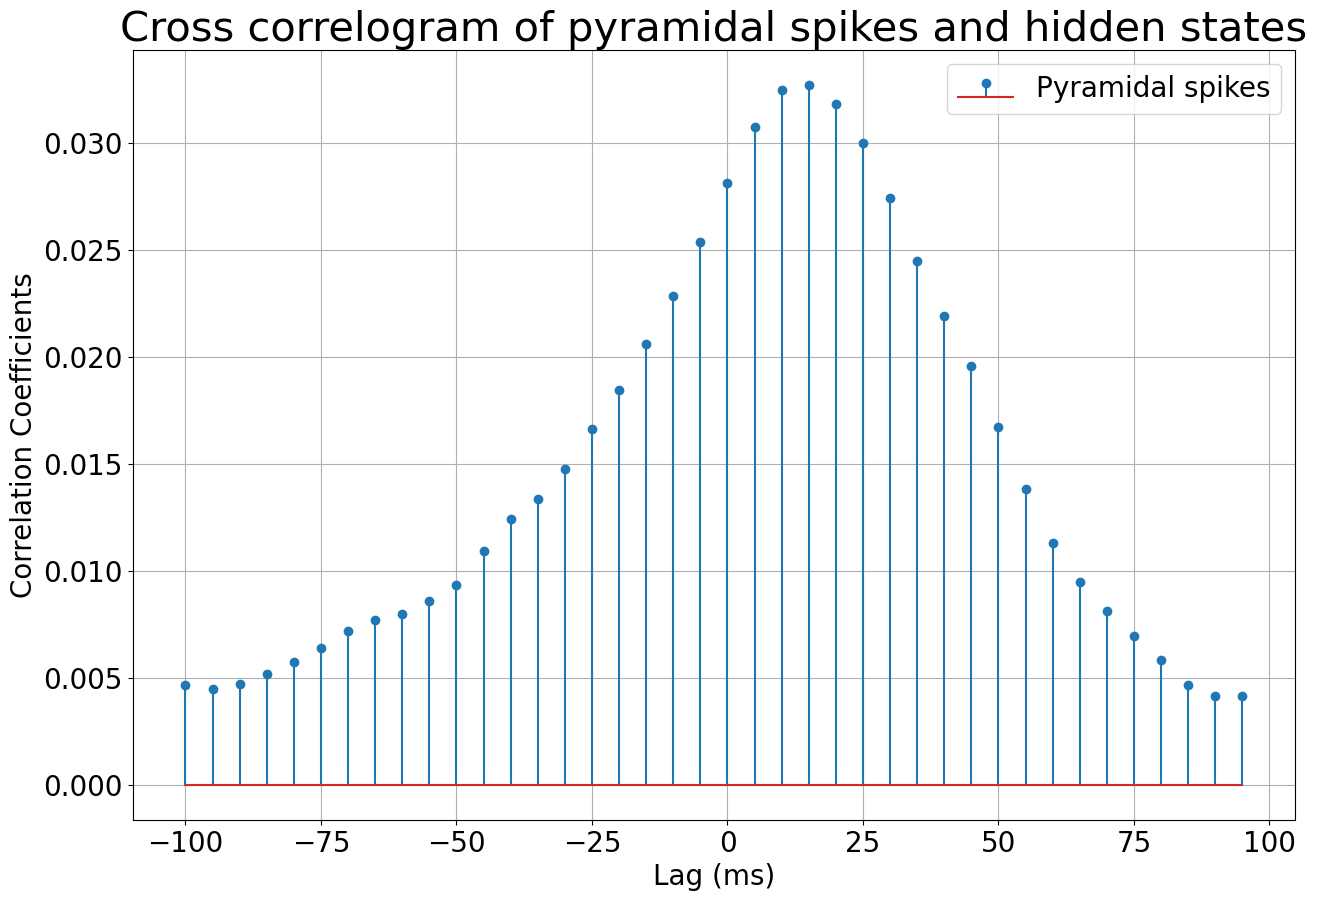

In [38]:
control_with_no_synapse = sio.loadmat("D:\\Internship2\\feedforward_sims\\output.mat")

#calculate PSD of subthreshold membrane potential and input current for control with no synapse
spikes = control_with_no_synapse['S_pyr_spikes']
hidden_state = sio.loadmat("D:\\Internship2\\feedforward_sims\\input_inhibitory_tau_50_sampling_20_kHz.mat")["hidden_state_i"]
hidden_state = hidden_state[:int(total_time/dt)]
hidden_state = np.squeeze(hidden_state)

#convert spike times to binary spikes
binary_spikes = np.zeros(int(total_time / dt))
for spike_time in spikes[0]:
    binary_spikes[int(spike_time / dt)] = 1

#plot color cross correlogram of spikes of pyramidal neuron and hidden state for control with no synapse
fig, ax = plt.subplots(figsize=(15,10)) 
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8']
plot_correlations(binary_spikes, hidden_state, 50, 'Pyramidal spikes', 'hidden states for gsyn=0;delay=0', ax)
plt.title('Cross correlogram of pyramidal spikes and hidden states', fontsize=30)
plt.legend(['Pyramidal spikes'], fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Lag (ms)', fontsize=20)
plt.ylabel('Correlation Coefficients', fontsize=20)
